<font size="5">
  

# Predicting AirBnB Listing Prices - Comparing Random Forests and XGBoost

## COMP 4447 Data Scince Tools 1
Rodney Cordova

[Git Hub Repository](https://github.com/RDCordova/dst1-proj)
----



## Import modules

In [1]:
import pandas as pd 
import numpy as np 
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mapclassify as mc
from pprint import pprint
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectFromModel

## Import data
The dataset used in this analysis from the **[Inside Airbnb](http://insideairbnb.com/get-the-data.html)** site. Inside Airbnb aggregates data on listings and reviews from the AirBnB website. For this analysis we are using listings from Denver, Colorado.

In [2]:
url = 'http://data.insideairbnb.com/united-states/co/denver/2020-06-28/data/listings.csv.gz'
r = requests.get(url, allow_redirects=True)

open('listings.csv.gz', 'wb').write(r.content)

4872217

In [3]:
df = pd.read_csv('listings.csv.gz', compression='gzip')

In [4]:
df.head()

id                       listing_url       scrape_id last_scraped  \
0  177  https://www.airbnb.com/rooms/177  20200628212359   2020-06-29   
1  360  https://www.airbnb.com/rooms/360  20200628212359   2020-06-29   
2  364  https://www.airbnb.com/rooms/364  20200628212359   2020-06-29   
3  590  https://www.airbnb.com/rooms/590  20200628212359   2020-06-29   
4  592  https://www.airbnb.com/rooms/592  20200628212359   2020-06-29   

                                                name  \
0   Tiny Home in the Heart of the City- ECO FRIENDLY   
1  Sit in the Peaceful Garden of the Chickadee Co...   
2                Lodo / RiNo LOFT  via airport train   
3                  Comfortable  - and a great value!   
4                                            private   

                                             summary  \
0  160 sq ft + 80 sq ft loft for sleeping, Sleeps...   
1  Enjoy the famous Colorado weather and unplug i...   
2  Modern 1,000 square foot loft in the heart of ...   
3  Large guest room in my home, where I also live...   
4  This room is in the basement.  It does not hav...   

                                               space  \
0  Here's the fun details of this Tiny Home exper...   
1  Chickadee Cottage is the largest of our guest ...   
2  BRAND NEW FOR 2016 -  April 22, 2016 - the air...   
3  I have been enjoying welcoming many wonderful ...   
4  This is a basement room.  You can sometimes he...   

                                         description experiences_offered  \
0  160 sq ft + 80 sq ft loft for sleeping, Sleeps...                none   
1  Enjoy the famous Colorado weather and unplug i...                none   
2  Modern 1,000 square foot loft in the heart of ...                none   
3  Large guest room in my home, where I also live...                none   
4  This room is in the basement.  It does not hav...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Quiet neighborhood next to park, creeks and bi...  ...                f   
1  The cottage is located in the center of Lower ...  ...                f   
2  Ten brewpubs within walking distance, two grea...  ...                f   
3  I love the diversity of my neighborhood and it...  ...                f   
4                                                NaN  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f  strict_14_with_grace_period   
2                        f  strict_14_with_grace_period   
3                        f                     flexible   
4                        f                     flexible   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             t                                t   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               3   
1                               2   
2                               1   
3                               2   
4                               2   

   calculated_host_listings_count_entire_homes  \
0                                            3   
1                                            2   
2                                            1   
3                                            0   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            2   
4                                            2   

   calculated_host_listings_count_share

In [5]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

## Data Cleaning 

In [6]:
#columns
for i in df.columns:
    print(i)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

### I - Feature Reduction

In [7]:
#remove urls 
df.drop(columns = ['listing_url','thumbnail_url','medium_url','picture_url',
                  'xl_picture_url','host_url','host_thumbnail_url','host_picture_url'], inplace = True)

In [8]:
#remove text features
df.drop(columns = ['name','summary','space','description','neighborhood_overview',
                  'notes','transit','access','interaction','house_rules','host_about',
                  'host_verifications','amenities','jurisdiction_names','host_name','host_location','calendar_updated'
                  ,'license'], inplace = True)

In [9]:
#duplicate features.
# street = City, state, country - street removed
# mart_location = City, state - market_location removed
# country_code = country - country_code removed 
# host_listings_count = host_total_listings_count - host_listings_count removed
# market = Denver

df.drop(columns = ['street','smart_location','country_code','host_listings_count','market','neighbourhood'],inplace = True)

In [10]:
#remove signle unique Value
df['state'] = df['state'].str.lower()
for i in df.columns:
    if df[i].nunique() == 1 or df[i].nunique() == 0:
        print(i + " : " + str(df[i].nunique()) + " : Unique Value =" +str(df[i].unique()))

scrape_id : 1 : Unique Value =[20200628212359]
experiences_offered : 1 : Unique Value =['none']
neighbourhood_group_cleansed : 0 : Unique Value =[nan]
state : 1 : Unique Value =['co']
country : 1 : Unique Value =['United States']
has_availability : 1 : Unique Value =['t']
is_business_travel_ready : 1 : Unique Value =['f']


In [11]:
df.drop(columns = ['scrape_id','experiences_offered','has_availability',
                   'is_business_travel_ready','neighbourhood_group_cleansed','country','state'],inplace = True)

### II - Feature Engineering 

In [12]:
#convert host_response_rate and host_acceptance_rate to floats 
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype('float').div(100)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype('float').div(100)

In [13]:
#convert dollar columns to floats
dollar = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in dollar:
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype('float')

In [14]:
#covert date to year and get the the differince in new column:
df['host_since'] = df['host_since'].astype('str')
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_scraped'] = df['last_scraped'].astype('str')
df['last_scraped'] = pd.to_datetime(df['last_scraped'])

df['host_for_years'] = (((df['last_scraped'] - df['host_since'])/ np.timedelta64(1, 'D')))/365

In [15]:
#convert first_reveiw and last reveiw in years. 
df['first_review'] = df['first_review'].astype('str')
df['first_review'] = ((df['last_scraped'] - pd.to_datetime(df['first_review'])) / np.timedelta64(1, 'D'))/365
df['last_review'] = df['last_review'].astype('str')
df['last_review'] = ((df['last_scraped'] - pd.to_datetime(df['last_review'])) / np.timedelta64(1, 'D'))/365

In [16]:
#remove scrape and date features
df.drop(columns = ['id','last_scraped','calendar_last_scraped','host_since'], inplace = True)

In [17]:
#change all catigoricals to lower for use in one hot encomding later
lower_cat = ['host_response_time','host_is_superhost','host_neighbourhood','host_has_profile_pic',
            'host_identity_verified','neighbourhood_cleansed','city','zipcode','property_type','room_type',
            'bed_type','requires_license','instant_bookable','cancellation_policy','require_guest_profile_picture',
            'require_guest_phone_verification']

for i in lower_cat:
    df[i] = df[i].str.lower()


In [18]:
#remove the 'co' from some zipcodes
df['zipcode'] = df['zipcode'].astype('str') 
df['zipcode'] = df['zipcode'].str.lstrip('co ')
df['zipcode'] = df['zipcode'].str.strip()
df['zipcode'] = df['zipcode'].replace('nan', np.nan)
df['zipcode'].unique()


array(['80246', '80211', '80205', '80207', '80223', '80220', '80203',
       '80110', '80209', '80202', '80218', '80206', '80230', '80212',
       '80210', '80222', '80219', '80238', '80204', nan, '80247', '80249',
       '80231', '80235', '80113', '80227', '80237', '80236', '80224',
       '80221', '80214', '80216', '80123', '80014', '80033', '80239',
       '80011', '80010', '80019', '80127', '81427', '80226'], dtype=object)

In [19]:
#check feature types
for i in df.columns:
    print(i + " : " + str(df[i].dtype))

host_id : int64
host_response_time : object
host_response_rate : float64
host_acceptance_rate : float64
host_is_superhost : object
host_neighbourhood : object
host_total_listings_count : int64
host_has_profile_pic : object
host_identity_verified : object
neighbourhood_cleansed : object
city : object
zipcode : object
latitude : float64
longitude : float64
is_location_exact : object
property_type : object
room_type : object
accommodates : int64
bathrooms : float64
bedrooms : float64
beds : float64
bed_type : object
square_feet : float64
price : float64
weekly_price : float64
monthly_price : float64
security_deposit : float64
cleaning_fee : float64
guests_included : int64
extra_people : float64
minimum_nights : int64
maximum_nights : int64
minimum_minimum_nights : int64
maximum_minimum_nights : int64
minimum_maximum_nights : int64
maximum_maximum_nights : int64
minimum_nights_avg_ntm : float64
maximum_nights_avg_ntm : float64
availability_30 : int64
availability_60 : int64
availability_90

### III - Missing Values

In [20]:
#missing 
df.isnull().sum().sum()

22371

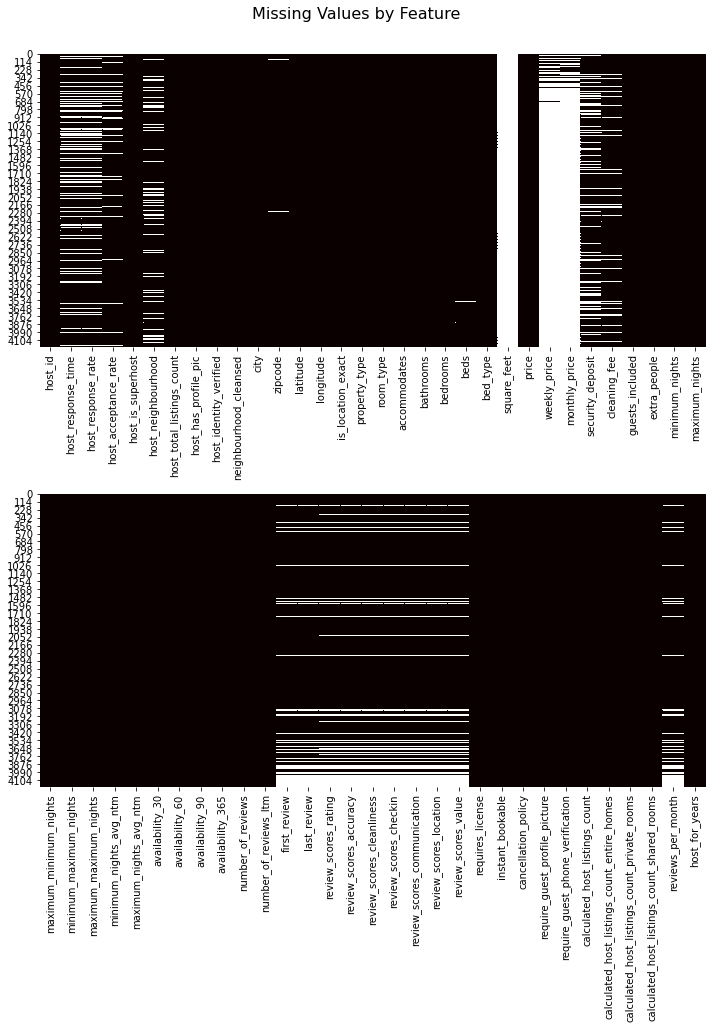

In [21]:
%matplotlib inline 
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
fig, axes = plt.subplots(2, 1, figsize = (10,15))
plt.suptitle("Missing Values by Feature", size=16)
sns.heatmap(df.iloc[:, 0:32].isnull(), cbar=False, cmap='hot',ax = axes[0])
sns.heatmap(df.iloc[:, 33:].isnull(), cbar=False, cmap='hot',ax = axes[1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [22]:
#search for high rates of missing values 
for i in df.columns:
    missing_rate = df[i].isnull().sum() / df[i].shape[0]
    if missing_rate >0.6:
        print(i + " - " + str(missing_rate))

square_feet - 0.9959523809523809
weekly_price - 0.9319047619047619
monthly_price - 0.9414285714285714


In [23]:
#drop hgih missing rate
df.drop(columns = ['square_feet','weekly_price','monthly_price'],inplace=True)

In [24]:
# Impute missing data. For float / int column impute = mean. For catigorical column impute = mode   
for i in df.columns:
    if df[i].dtype == float or df[i].dtype == int:
        df[i].fillna(df[i].mean(), inplace=True)
    else:
        df[i].fillna(df[i].mode()[0], inplace=True)

In [25]:
df.isnull().sum().sum()

0

## Exploratory Data Analysis

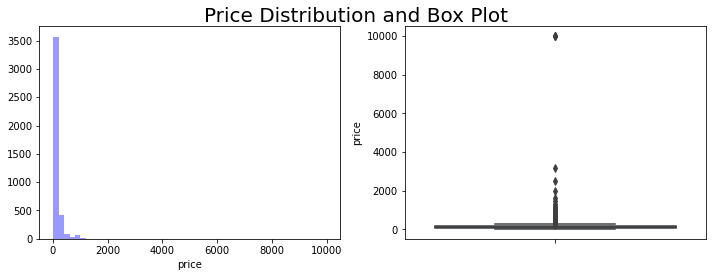

In [26]:
#access price distrbution 
fig, axes = plt.subplots(1,2, figsize = (10,4))
plt.suptitle("Price Distribution and Box Plot", size=20)
plt.tight_layout()
sns.distplot(df['price'],kde=False, color="b",ax=axes[0])
sns.boxplot(y='price',data=df)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [27]:
#check threshould for price outliers
df['price'].mean() + 3 * df['price'].std()

1208.1092640061463

In [28]:
#identify outliers
outliers = df[df['price'] > df['price'].mean() + 3 * df['price'].std()]
outliers['price']

682      9999.0
1309    10000.0
1792     1299.0
1964     1450.0
2541     9999.0
2956    10000.0
3204     2500.0
3334     3200.0
3719     2000.0
3819     1599.0
Name: price, dtype: float64

In [29]:
#drop outliers
df = df[df['price'] < df['price'].mean() + 3 * df['price'].std()]

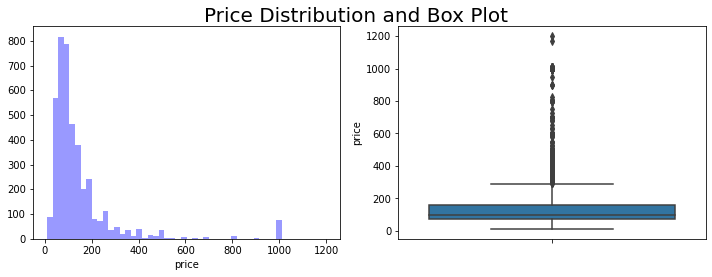

In [30]:
#reaccess price distobution
fig, axes = plt.subplots(1,2, figsize = (10,4))
plt.suptitle("Price Distribution and Box Plot", size=20)
sns.distplot(df['price'],kde=False, color="b",ax=axes[0])
sns.boxplot(y='price',data=df)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [31]:
df = df[df['price'] < df['price'].mean() + 3 * df['price'].std()]

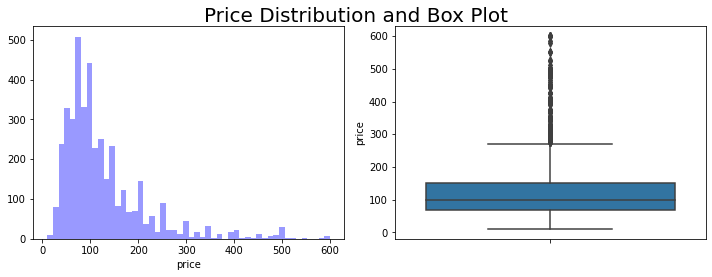

In [32]:
#reaccess price distobution
fig, axes = plt.subplots(1,2, figsize = (10,4))
plt.suptitle("Price Distribution and Box Plot", size=20)
sns.distplot(df['price'],kde=False, color="b",ax=axes[0])
sns.boxplot(y='price',data=df)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [33]:
df['price'].mean()

126.26689520078355

In [34]:
#geojson
geo_url = 'http://data.insideairbnb.com/united-states/co/denver/2020-06-28/visualisations/neighbourhoods.geojson' 
geo_r = requests.get(geo_url, allow_redirects=True)

with open('denver_geo.json', 'wb') as f:
     f.write(geo_r.content)
        
geo_df=gpd.read_file('denver_geo.json')
geo_df['neighbourhood'] = geo_df['neighbourhood'].str.lower()
neighbourhood_mean = df.groupby('neighbourhood_cleansed')['price'].mean()
geo_df = pd.merge(geo_df, neighbourhood_mean, left_on='neighbourhood',right_on='neighbourhood_cleansed',how='outer')

In [35]:
geo_df.drop(columns = 'neighbourhood_group',inplace = True)

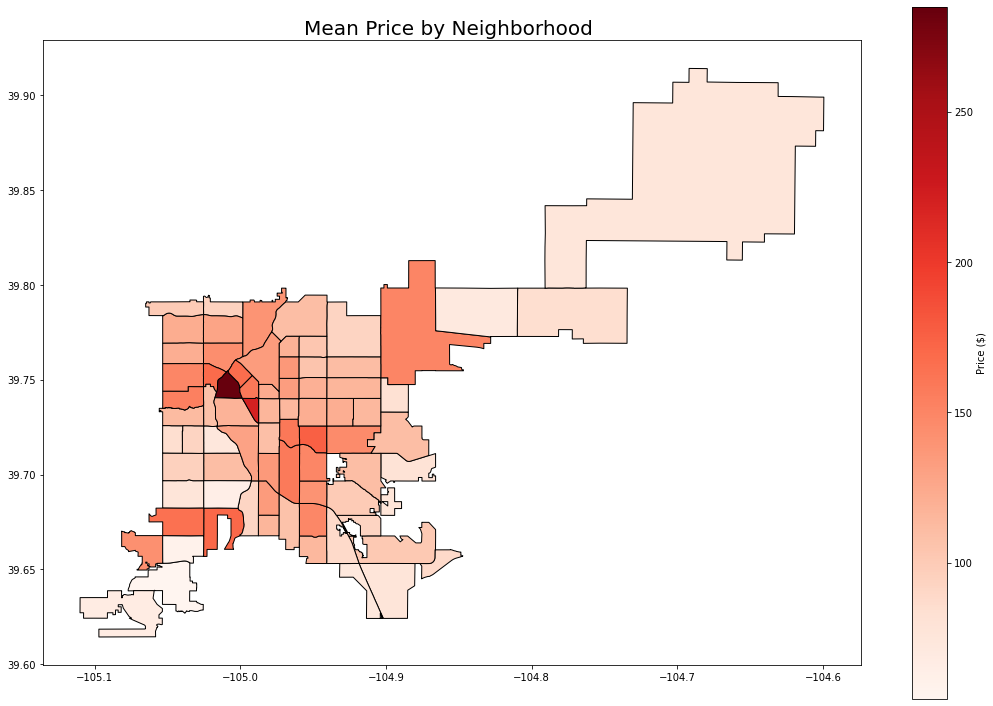

In [36]:
geo_df.plot(column='price', 
            figsize=(15, 10),
            edgecolor='black',
            cmap='Reds',
            legend=True,
           legend_kwds={'label': "Price ($)"})
plt.title('Mean Price by Neighborhood ',fontsize=20)
plt.tight_layout()

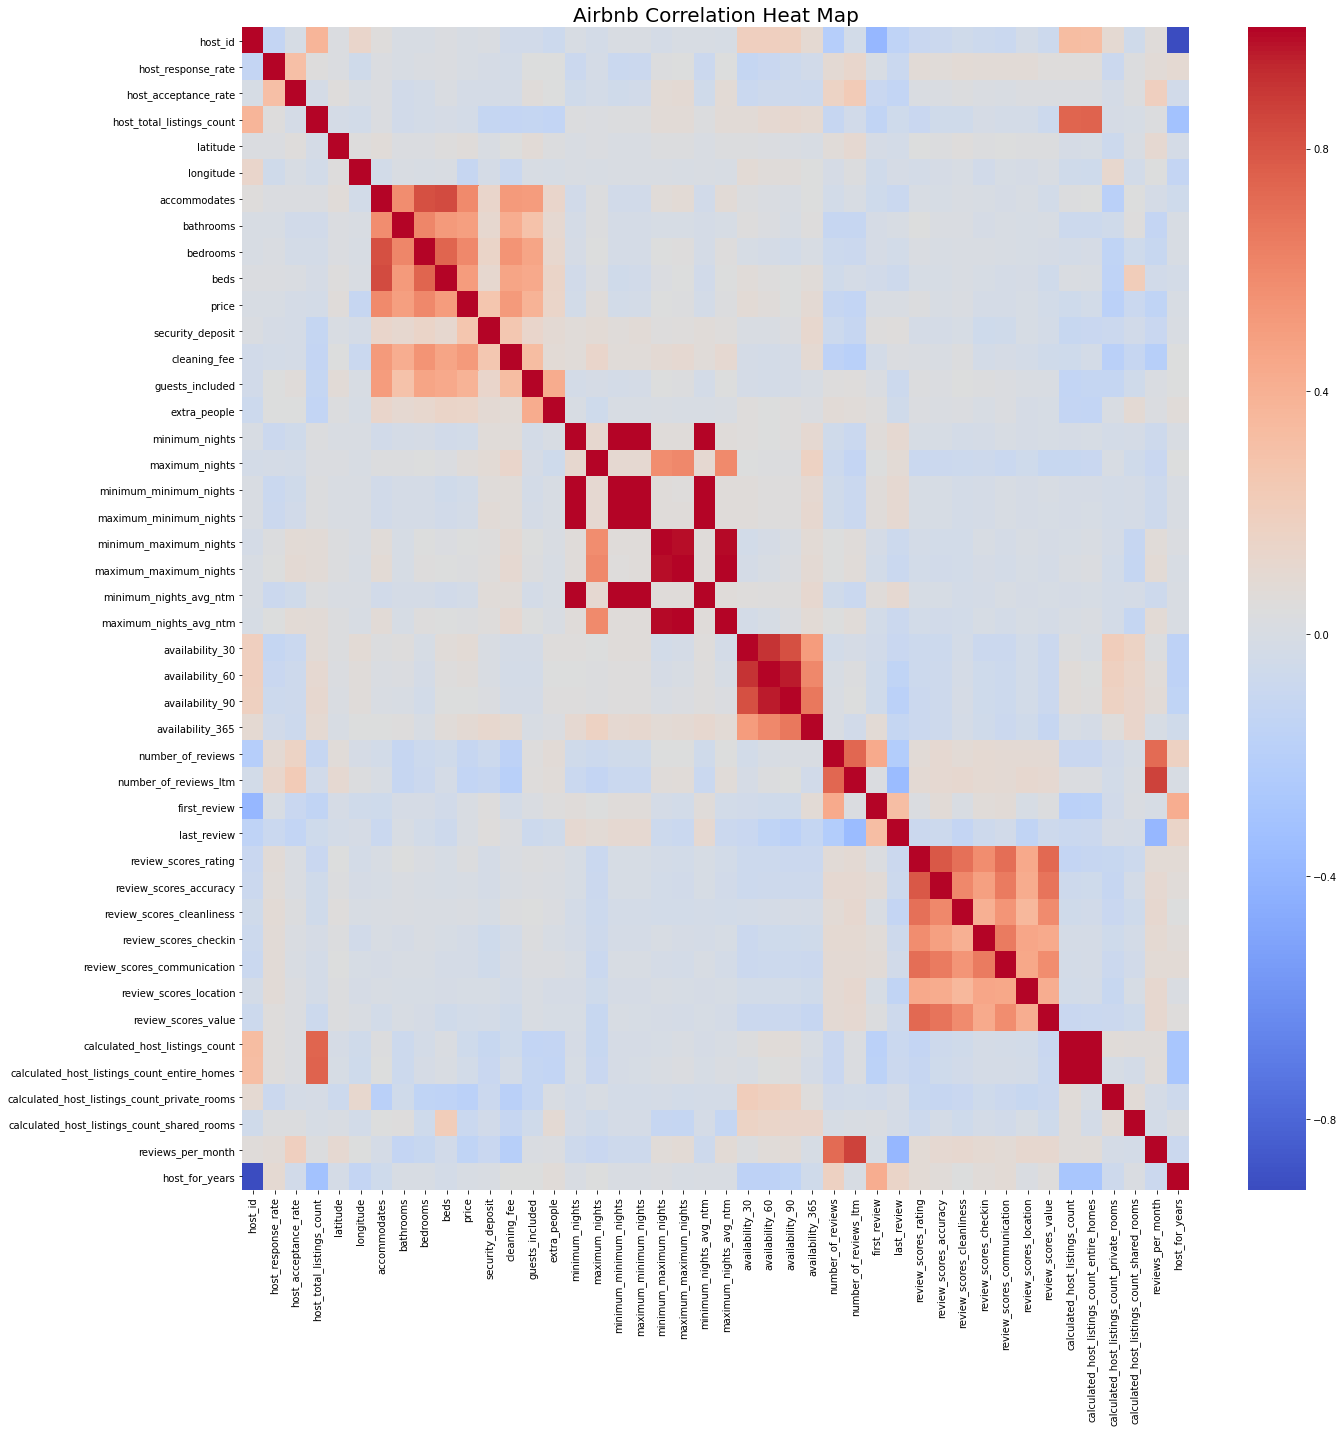

In [37]:
fig, ax = plt.subplots(figsize=(20,20))
plt.title("Airbnb Correlation Heat Map", size=20)
sns.heatmap(df.corr(), cmap = 'coolwarm')
plt.tight_layout()
plt.show()


In [38]:
cor= df.corr().abs() 
upper =cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.90)]

In [39]:
high_corr

['minimum_minimum_nights',
 'maximum_minimum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_60',
 'availability_90',
 'calculated_host_listings_count_entire_homes',
 'host_for_years']

In [40]:
df.drop(columns = high_corr, inplace = True)

In [41]:
for i in df.columns:
    print(i)

host_id
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_neighbourhood
host_total_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
city
zipcode
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_maximum_nights
availability_30
availability_365
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_license
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month


In [42]:
df_catigorical = df.select_dtypes(include = 'object').copy()

df_stats = pd.DataFrame(columns = ['column', 'values'])
tmp = pd.DataFrame()

for c  in df_catigorical.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_catigorical[c].unique()]
    tmp['values_count_incna'] = len(list(df_catigorical[c].unique()))
    tmp['values_count_nona'] = int(df_catigorical[c].nunique())
    df_stats = df_stats.append(tmp)

df_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = False)
df_stats.set_index('column', inplace = True)
df_stats

values  \
column                                                                                
host_neighbourhood                [virginia village, highland, five points, nort...   
neighbourhood_cleansed            [virginia village, highland, five points, nort...   
zipcode                           [80246, 80211, 80205, 80207, 80223, 80220, 802...   
property_type                     [guesthouse, loft, house, apartment, guest sui...   
city                              [denver, englewood, lakewood, wheat ridge, aur...   
cancellation_policy               [strict_14_with_grace_period, flexible, modera...   
bed_type                            [real bed, futon, airbed, pull-out sofa, couch]   
host_response_time                [within an hour, within a few hours, within a ...   
room_type                         [entire home/apt, private room, shared room, h...   
requires_license                                                             [t, f]   
require_guest_profile_picture                                                [f, t]   
instant_bookable                                                             [f, t]   
is_location_exact                                                            [t, f]   
host_is_superhost                                                            [t, f]   
host_identity_verified                                                       [t, f]   
host_has_profile_pic                                                         [t, f]   
require_guest_phone_verification                                             [f, t]   

                                  values_count_incna  values_count_nona  
column                                                                   
host_neighbourhood                             118.0              118.0  
neighbourhood_cleansed                          78.0               78.0  
zipcode                                         41.0               41.0  
property_type                                   20.0               20.0  
city                                             9.0                9.0  
cancellation_policy                              5.0                5.0  
bed_type                                         5.0                5.0  
host_response_time                               4.0                4.0  
room_type                                        4.0                4.0  
requires_license                                 2.0                2.0  
require_guest_profile_picture                    2.0                2.0  
instant_bookable                                 2.0                2.0  
is_location_exact                                2.0                2.0  
host_is_superhost                                2.0                2.0  
host_identity_verified                           2.0                2.0  
host_has_profile_pic                             2.0                2.0  
require_guest_phone_verification                 2.0                2.0

In [43]:
df_catigorical['price'] = df.loc[df_catigorical.index, 'price'].copy()

In [44]:
df_catigorical_big = df_catigorical[['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type']]
df_catigorical.drop(columns = ['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type'],inplace = True)

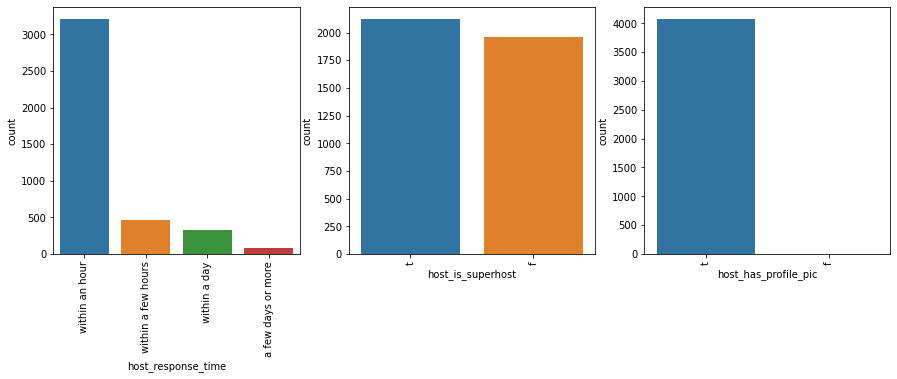

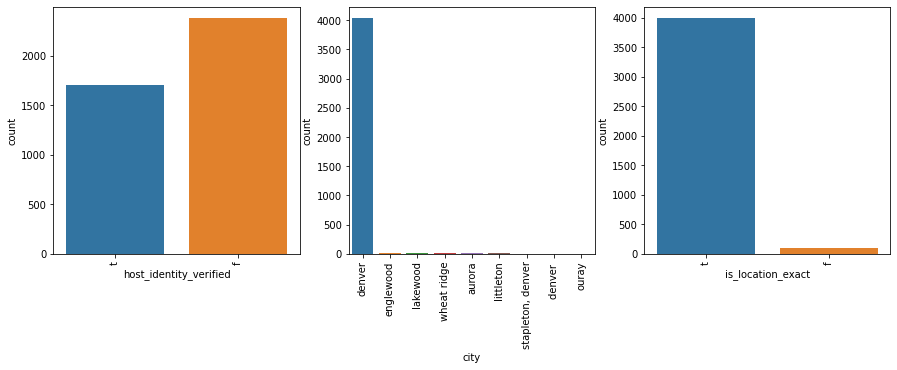

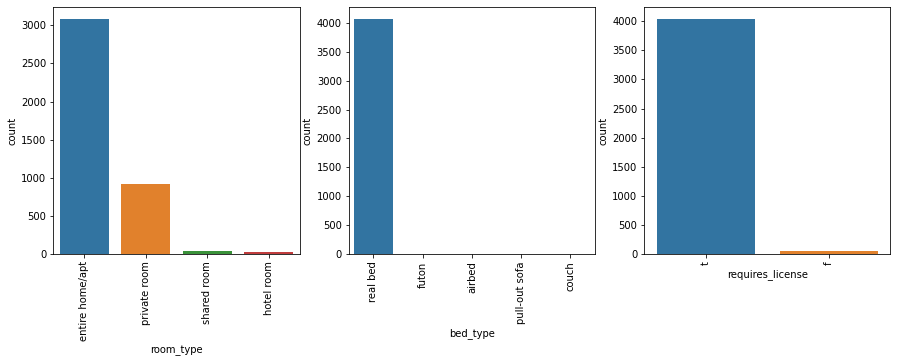

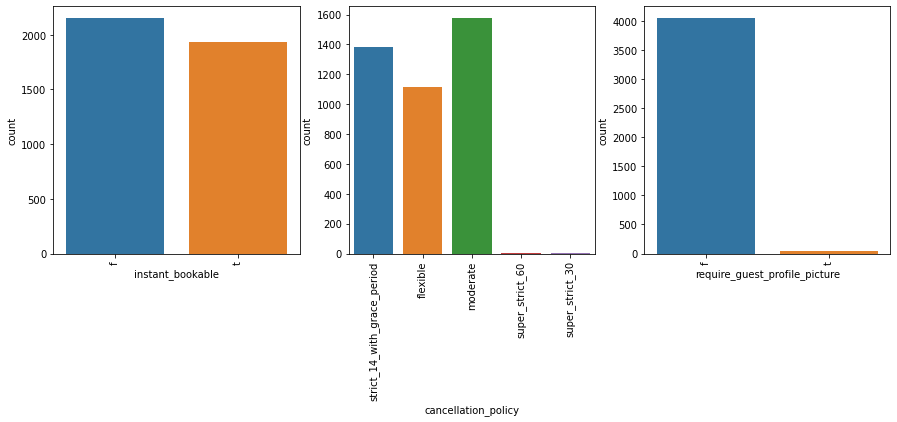

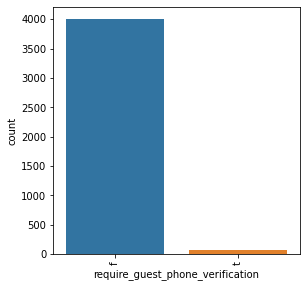

In [45]:
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(df_catigorical.columns):
    if ix <= 3:
        if c != 'price':
            ax1 = fig.add_subplot(2,3,ix)
            chart = sns.countplot(data = df_catigorical, x=c, ax = ax1)
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

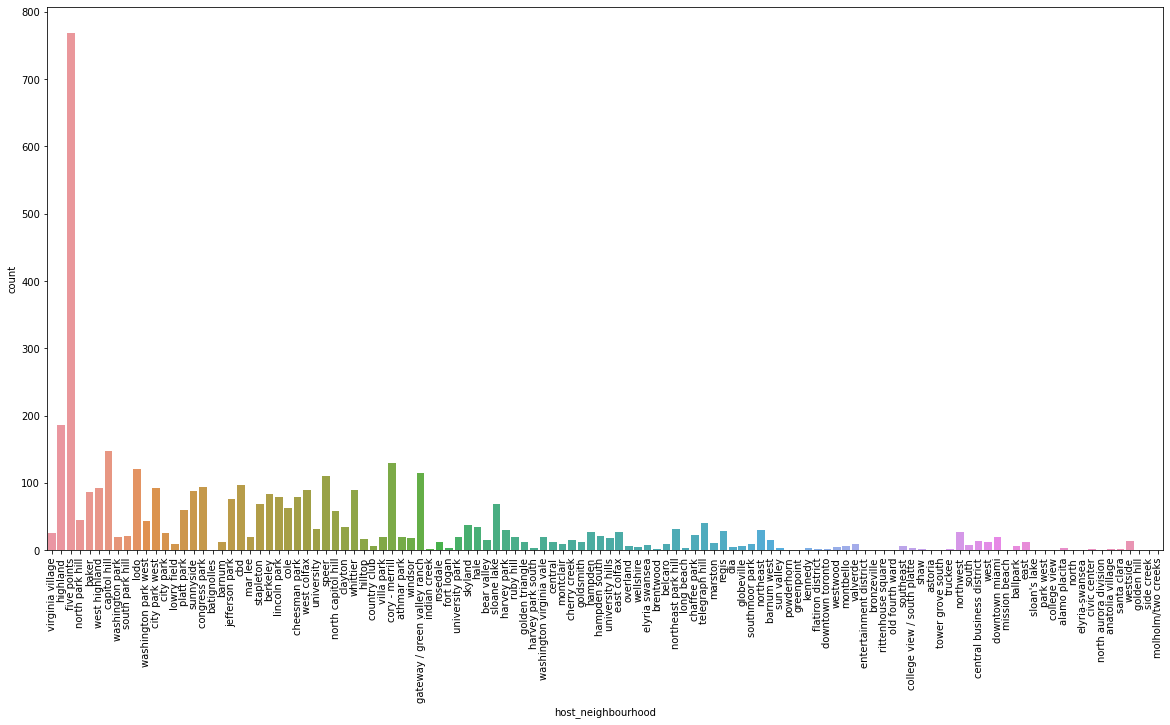

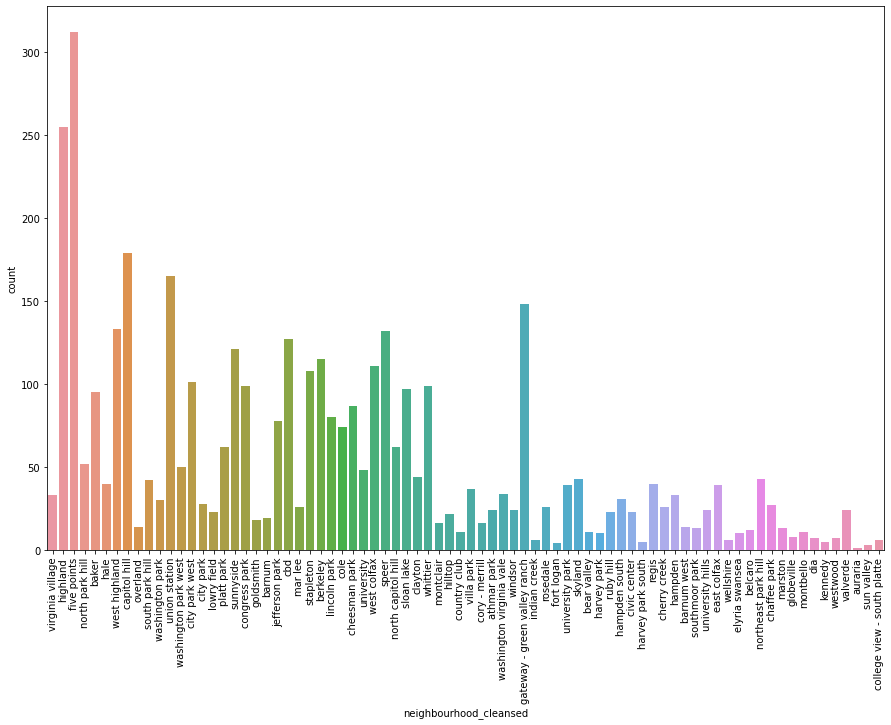

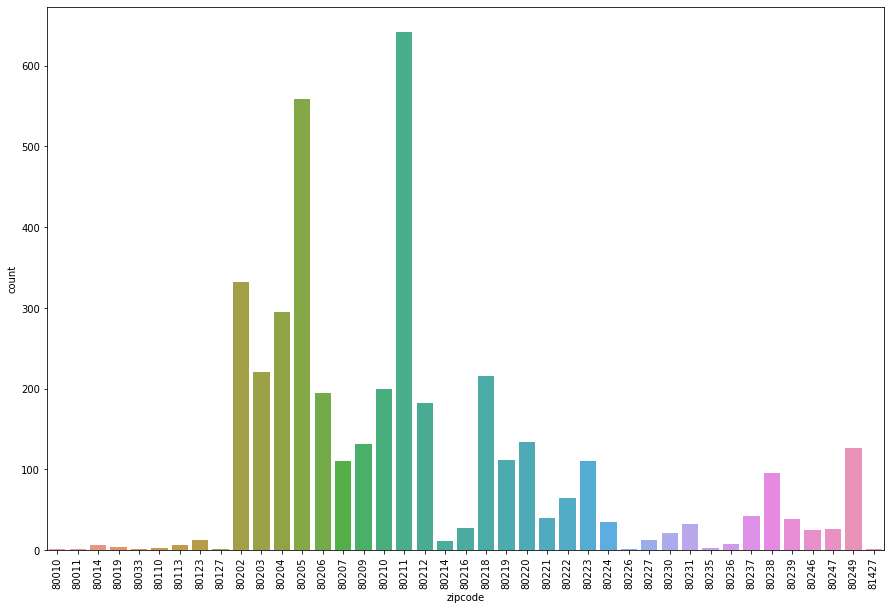

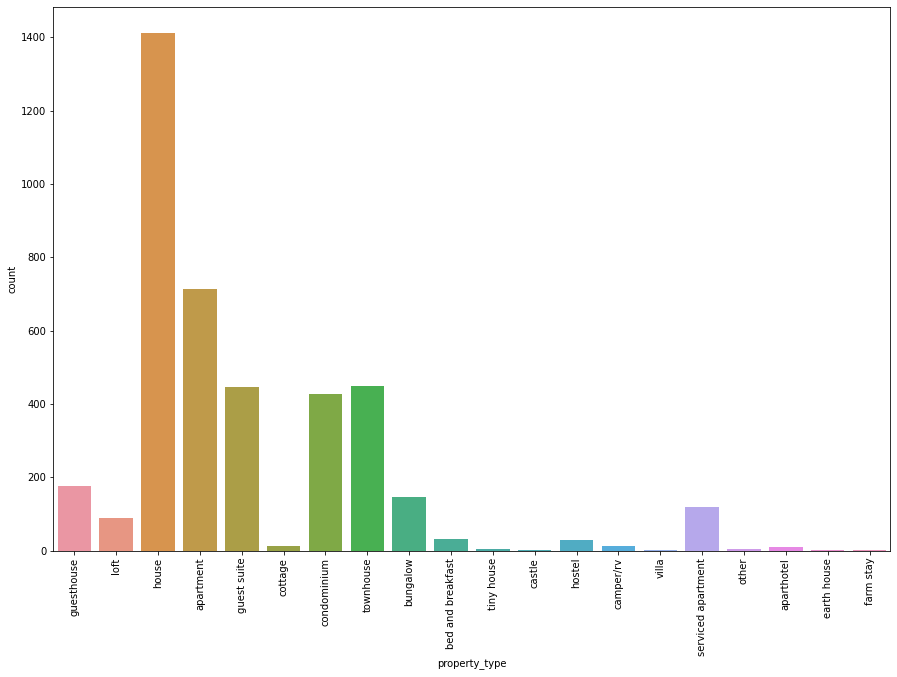

<Figure size 1080x720 with 0 Axes>

In [46]:
fig = plt.figure(figsize = (20,10))
for c in list(df_catigorical_big.columns):
    if c != 'price':
        ax1 = fig.add_subplot(1,1,1)
        chart = sns.countplot(data = df_catigorical_big, x=c, ax = ax1)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    fig = plt.figure(figsize = (15,10))


In [47]:
print(df.groupby('host_has_profile_pic')['host_id'].count())
print(df.groupby('bed_type')['host_id'].count())

host_has_profile_pic
f       5
t    4079
Name: host_id, dtype: int64
bed_type
airbed              3
couch               2
futon               8
pull-out sofa       7
real bed         4064
Name: host_id, dtype: int64


In [48]:
cat_update = ['city','bed_type','property_type','host_neighbourhood']
for j in cat_update:
    frequencies = df[j].value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > 0.1).idxmax()]
    df[j] = df[j].mask(df[j].map(df[j].value_counts(normalize=True)) < threshold, 'Other')


In [49]:
df_catigorical = df.select_dtypes(include = 'object').copy()

df_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona'])
tmp = pd.DataFrame()

for c  in df_catigorical.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_catigorical[c].unique()]
    tmp['values_count_incna'] = len(list(df_catigorical[c].unique()))
    tmp['values_count_nona'] = int(df_catigorical[c].nunique())
    df_stats = df_stats.append(tmp)

df_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = False)
df_stats.set_index('column', inplace = True)
df_stats

values  \
column                                                                                
neighbourhood_cleansed            [virginia village, highland, five points, nort...   
host_neighbourhood                [virginia village, highland, five points, nort...   
zipcode                           [80246, 80211, 80205, 80207, 80223, 80220, 802...   
property_type                     [guesthouse, Other, house, apartment, guest su...   
cancellation_policy               [strict_14_with_grace_period, flexible, modera...   
host_response_time                [within an hour, within a few hours, within a ...   
room_type                         [entire home/apt, private room, shared room, h...   
bed_type                                                          [real bed, Other]   
require_guest_profile_picture                                                [f, t]   
instant_bookable                                                             [f, t]   
requires_license                                                             [t, f]   
is_location_exact                                                            [t, f]   
host_is_superhost                                                            [t, f]   
city                                                                [denver, Other]   
host_identity_verified                                                       [t, f]   
host_has_profile_pic                                                         [t, f]   
require_guest_phone_verification                                             [f, t]   

                                 values_count_incna values_count_nona  
column                                                                 
neighbourhood_cleansed                           78                78  
host_neighbourhood                               52                52  
zipcode                                          41                41  
property_type                                     8                 8  
cancellation_policy                               5                 5  
host_response_time                                4                 4  
room_type                                         4                 4  
bed_type                                          2                 2  
require_guest_profile_picture                     2                 2  
instant_bookable                                  2                 2  
requires_license                                  2                 2  
is_location_exact                                 2                 2  
host_is_superhost                                 2                 2  
city                                              2                 2  
host_identity_verified                            2                 2  
host_has_profile_pic                              2                 2  
require_guest_phone_verification                  2                 2

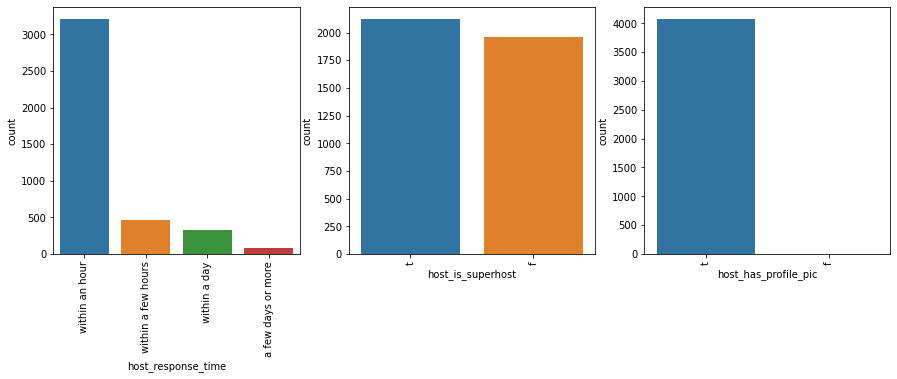

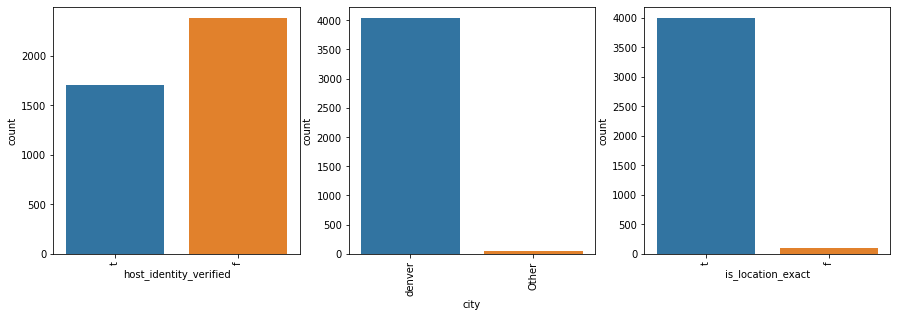

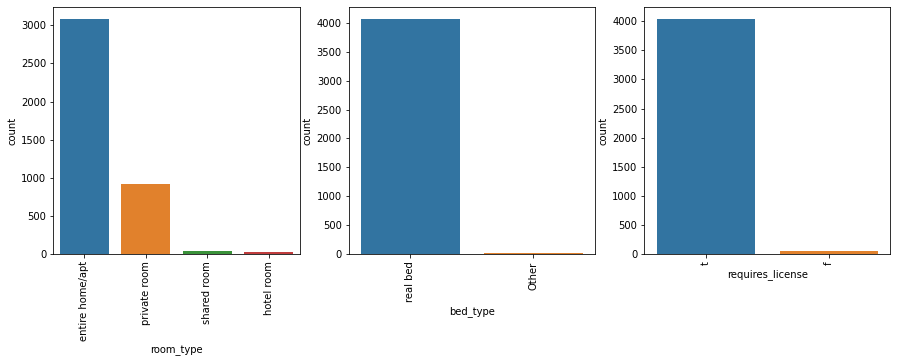

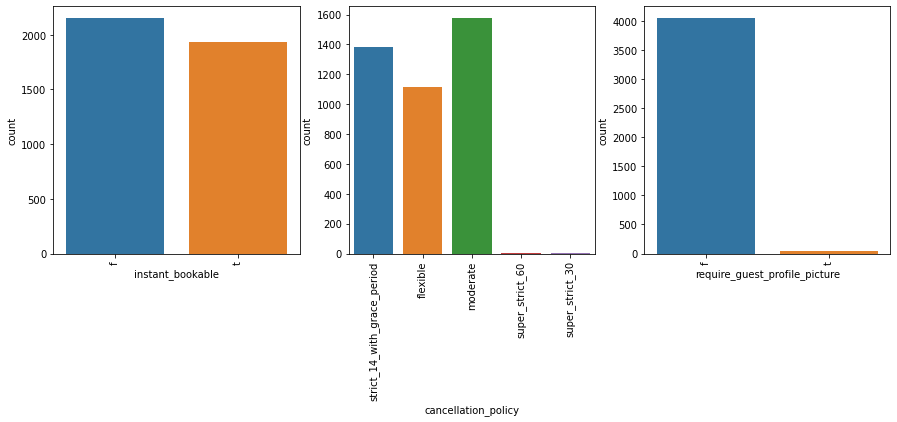

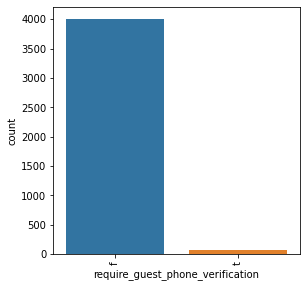

In [50]:
df_catigorical['price'] = df.loc[df_catigorical.index, 'price'].copy()
df_catigorical_big = df_catigorical[['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type']]
df_catigorical.drop(columns = ['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type'],inplace = True)
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(df_catigorical.columns):
    if ix <= 3:
        if c != 'price':
            ax1 = fig.add_subplot(2,3,ix)
            chart = sns.countplot(data = df_catigorical, x=c, ax = ax1)
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1


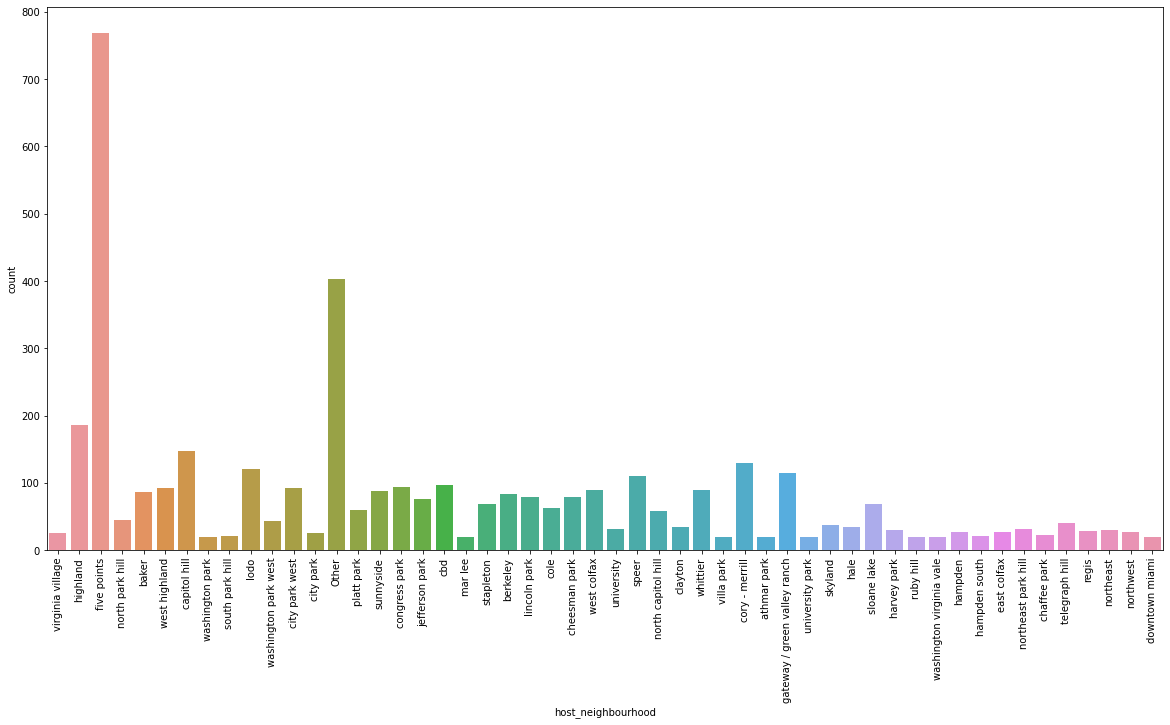

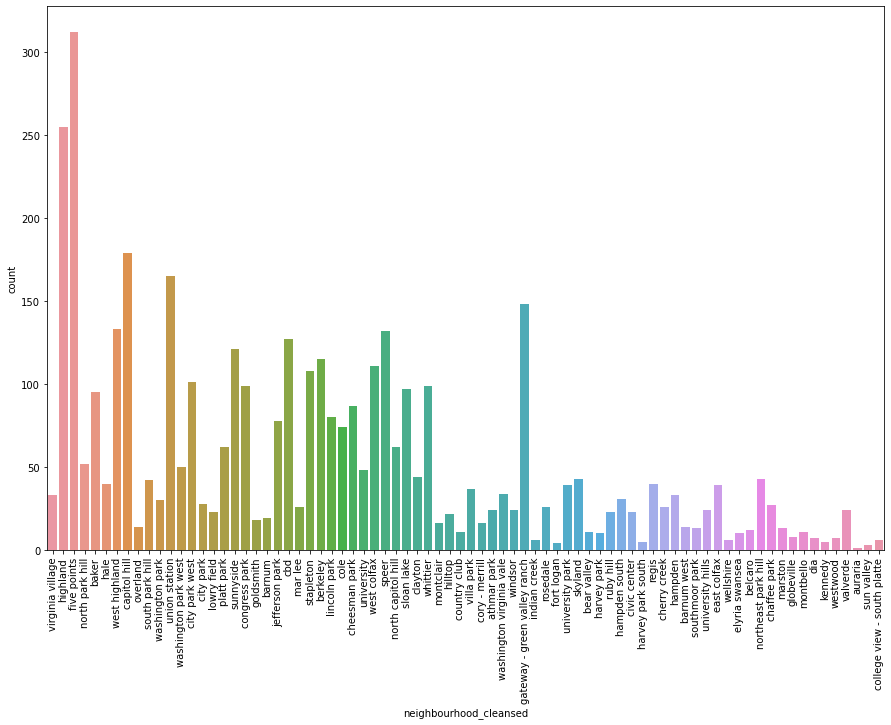

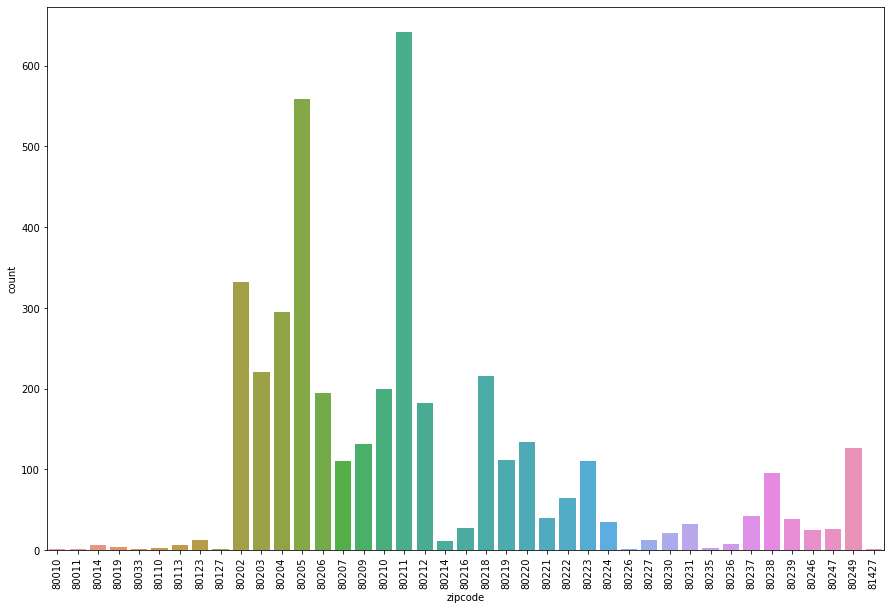

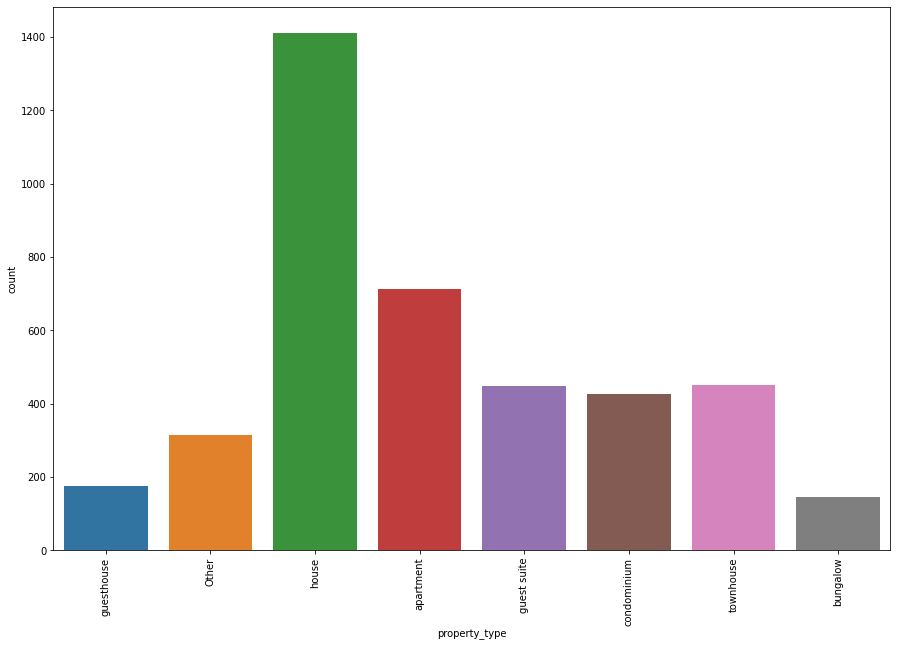

<Figure size 1080x720 with 0 Axes>

In [51]:
fig = plt.figure(figsize = (20,10))
for c in list(df_catigorical_big.columns):
    if c != 'price':
        ax1 = fig.add_subplot(1,1,1)
        chart = sns.countplot(data = df_catigorical_big, x=c, ax = ax1)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    fig = plt.figure(figsize = (15,10))


In [52]:
df_int_float = df.select_dtypes(include = ['int','float']).copy()

In [53]:
df_int_float.describe()

host_id  host_response_rate  host_acceptance_rate  \
count  4.084000e+03         4084.000000           4084.000000   
mean   1.005100e+08            0.956292              0.921273   
std    1.001329e+08            0.131699              0.149889   
min    6.150000e+02            0.000000              0.000000   
25%    1.923811e+07            0.949928              0.921816   
50%    5.572628e+07            1.000000              0.970000   
75%    1.658454e+08            1.000000              1.000000   
max    3.520454e+08            1.000000              1.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                4084.000000  4084.000000  4084.000000   4084.000000   
mean                   32.535260    39.740472  -104.973844      4.073213   
std                   117.045792     0.032155     0.059352      2.614749   
min                     0.000000    39.624320  -105.109860      1.000000   
25%                     1.000000    39.726960  -105.011292      2.000000   
50%                     1.000000    39.747375  -104.982485      4.000000   
75%                     3.000000    39.761450  -104.957125      5.000000   
max                  1018.000000    39.812460  -104.735070     24.000000   

         bathrooms     bedrooms         beds  ...  review_scores_accuracy  \
count  4084.000000  4084.000000  4084.000000  ...             4084.000000   
mean      1.426286     1.618989     2.068718  ...                9.838132   
std       0.831405     1.051746     1.542049  ...                0.515910   
min       0.000000     0.000000     0.000000  ...                2.000000   
25%       1.000000     1.000000     1.000000  ...                9.831081   
50%       1.000000     1.000000     2.000000  ...               10.000000   
75%       2.000000     2.000000     3.000000  ...               10.000000   
max      17.000000    12.000000    16.000000  ...               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                4084.000000            4084.000000   
mean                    9.751524               9.898250   
std                     0.597340               0.427743   
min                     2.000000               2.000000   
25%                     9.746340              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  4084.000000             4084.000000   
mean                      9.877968                9.856427   
std                       0.466242                0.407774   
min                       2.000000                2.000000   
25%                      10.000000                9.854970   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  calculated_host_listings_count  \
count          4084.000000                     4084.000000   
mean              9.692826                        7.458619   
std               0.598109                       20.763825   
min               2.000000                        1.000000   
25%               9.684596                        1.000000   
50%              10.000000                        1.000000   
75%              10.000000                        3.000000   
max              10.000000                      118.000000   

       calculated_host_listings_count_private_rooms  \
count                                   4084.000000   
mean                                       0.611166   
std                                        1.505035   
min                                        0.000000   
25%                                        0.000000   
50%                                        0.000000   
75%         

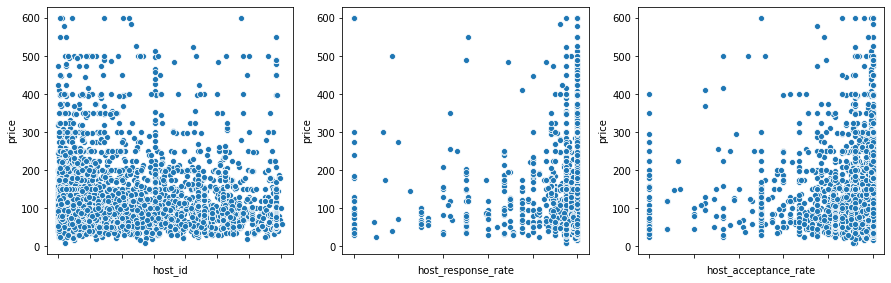

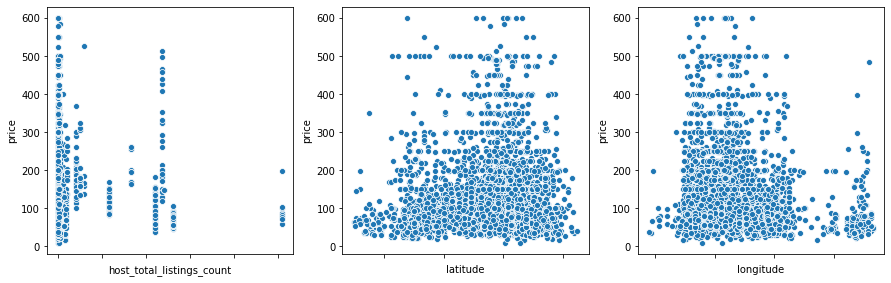

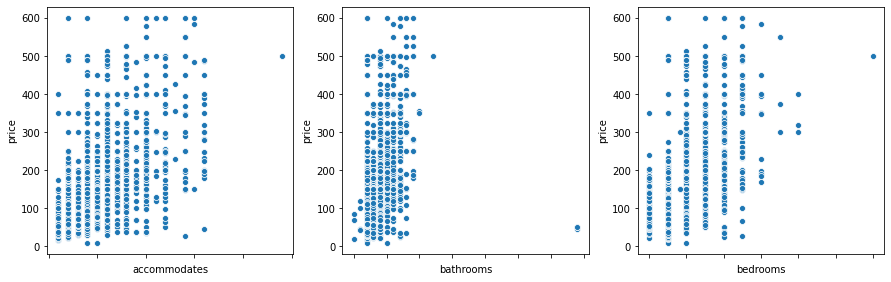

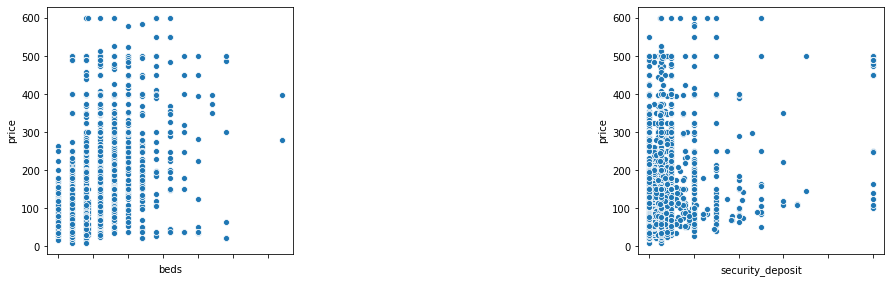

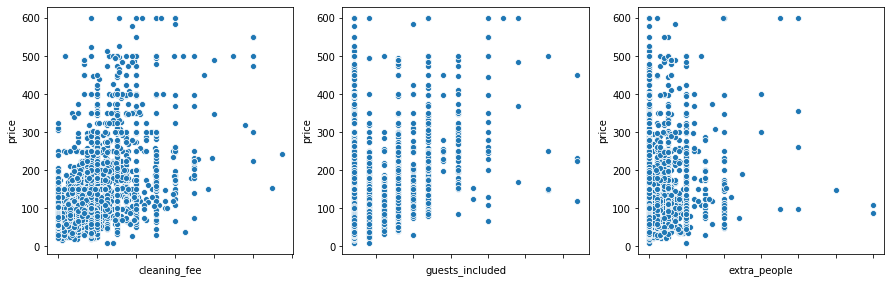

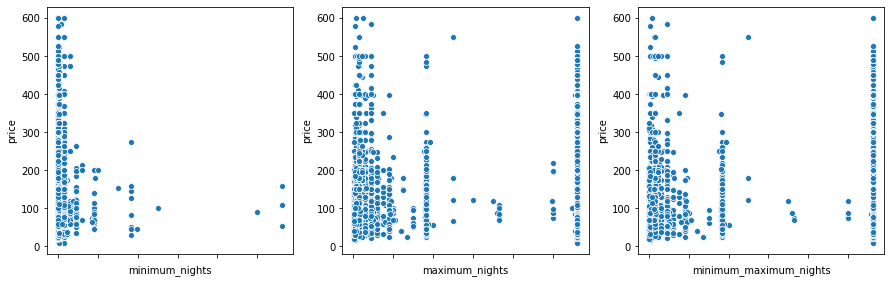

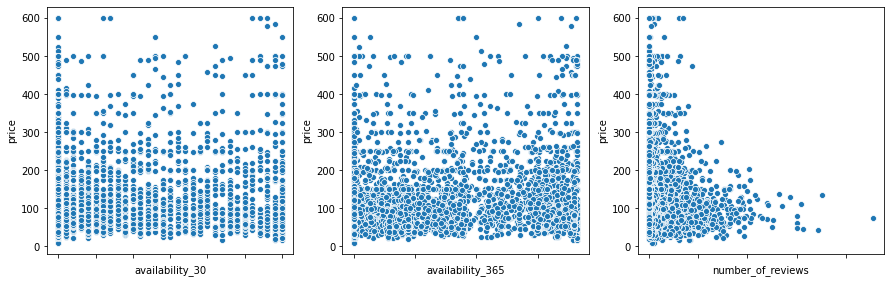

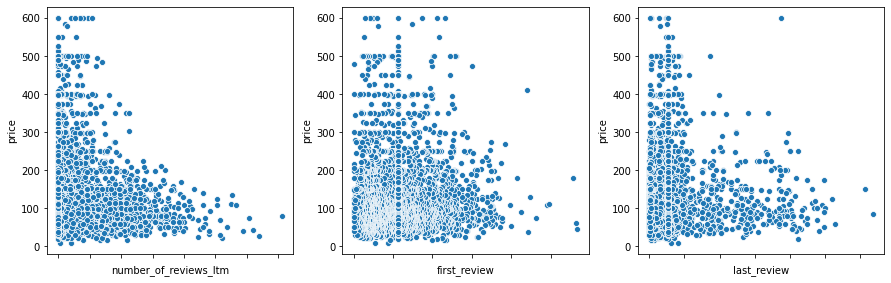

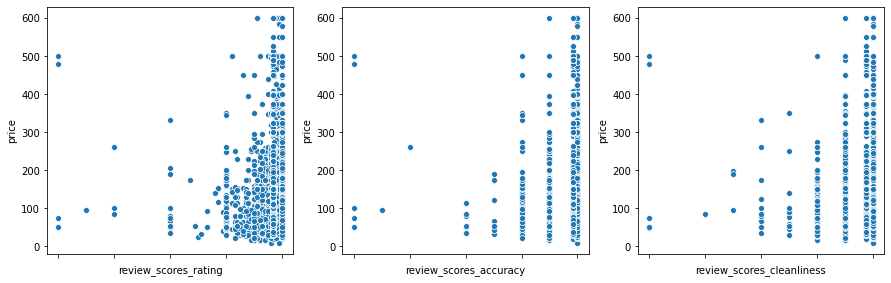

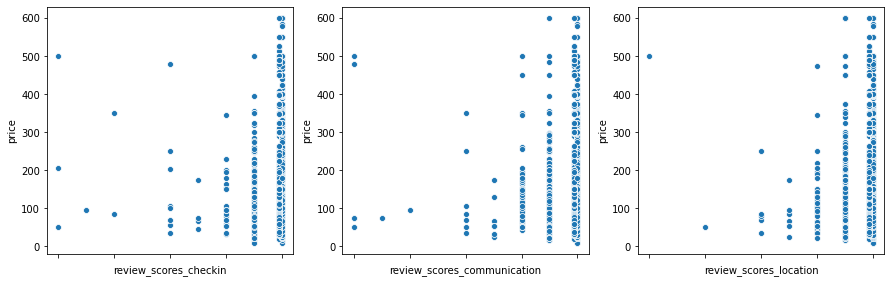

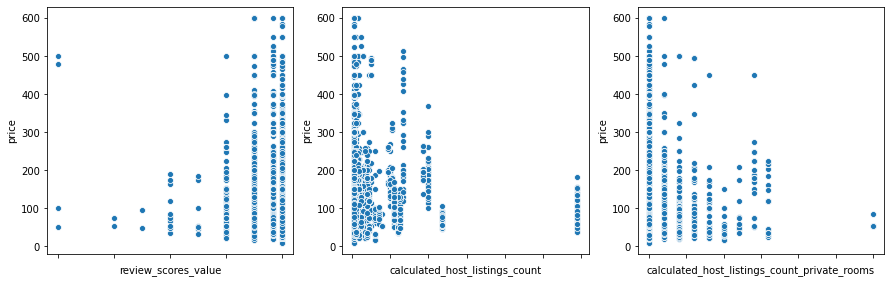

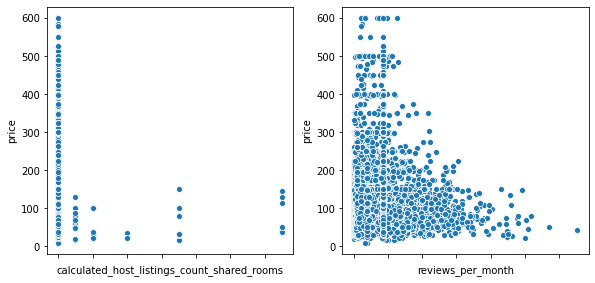

In [54]:
fig = plt.figure(figsize = (15,10))
ix = 1
for c in list(df_int_float.columns):
    if ix <= 3:
        if c != 'price':
            ax1 = fig.add_subplot(2,3,ix)
            chart = sns.scatterplot(x=c, y="price", data=df_int_float, ax=ax1)
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

 ## Model building 

### One-Hot Encoding

In [55]:
#split tagert variable into array.
y = df['price'].copy()
y.head()

0     56.0
1    140.0
2    179.0
3     61.0
4     45.0
Name: price, dtype: float64

In [56]:
#remove tagert varibale and one-hot incode all objects.
x = df.drop('price', axis=1)
x_encode = pd.get_dummies(x, columns=df.select_dtypes(include = 'object').columns)

In [57]:
x_encode.head()

host_id  host_response_rate  host_acceptance_rate  \
0      615            1.000000              0.980000   
1      666            1.000000              0.990000   
2      783            0.949928              0.921816   
3      933            1.000000              0.930000   
4      933            1.000000              0.930000   

   host_total_listings_count  latitude  longitude  accommodates  bathrooms  \
0                          2  39.69585 -104.92582             2        1.0   
1                          3  39.76703 -105.00256             3        1.0   
2                          1  39.76551 -104.97902             3        1.5   
3                          2  39.75361 -104.91237             3        1.0   
4                          2  39.75438 -104.91156             2        1.0   

   bedrooms  beds  ...  instant_bookable_t  cancellation_policy_flexible  \
0       0.0   0.0  ...                   0                             0   
1       2.0   2.0  ...                   0                             0   
2       1.0   1.0  ...                   0                             0   
3       1.0   1.0  ...                   0                             1   
4       1.0   1.0  ...                   0                             1   

   cancellation_policy_moderate  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   cancellation_policy_strict_14_with_grace_period  \
0                                                1   
1                                                1   
2                                                1   
3                                                0   
4                                                0   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  \
0                                    0                                    0   
1                                    0                                    0   
2                                    0                                    0   
3                                    0                                    0   
4                                    0                                    0   

   require_guest_profile_picture_f  require_guest_profile_picture_t  \
0                                1                                0   
1                                0                                1   
2                                1                                0   
3                                1                                0   
4                                1                                0   

   require_guest_phone_verification_f  require_guest_phone_verification_t  
0                                   1                                   0  
1                                   0                                   1  
2                                   1                                   0  
3                                   1                                   0  
4                                   1                                   0  

[5 rows x 246 columns]

In [58]:
#verify types
x_encode.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [59]:
#verify types
y.dtypes

dtype('float64')

### Split data into trianing and testing (70/30)

In [60]:
#split data set in to train and test
x_train, x_test, y_train, y_test = train_test_split(x_encode, y, test_size = 0.3,random_state=19)


In [61]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2858, 246)
Training Labels Shape: (2858,)
Testing Features Shape: (1226, 246)
Testing Labels Shape: (1226,)


### I - Baseline Model

In [62]:
mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape) * mean_train
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
print("Base Mean Absolute Error: {}".format(round(baseline_mae,4)))


Base Mean Absolute Error: 62.0476


### II - Random Forst 

In [63]:
#build model with 1000 trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 19)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=19)

In [64]:
#apply model to test
predictions = rf.predict(x_test)
base_mae = mean_absolute_error(predictions, y_test)
print('Base model - Mean Absolute Error: {}'.format(round(base_mae,4)))

Base model - Mean Absolute Error: 33.8743


In [65]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 19,
 'verbose': 0,
 'warm_start': False}


In [66]:
#random search -- create features
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [1, 2, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]

In [67]:
#random search -- build grid
random_grid = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

In [68]:
#random search search for hyperparameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=19, n_jobs = -1)

In [69]:
#random search -- fit new model 
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=1000,
                                                   random_state=19),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [1, 2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=19, verbose=2)

In [70]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [71]:
random_predictions = rf_random.predict(x_test)
best_random_mae = mean_absolute_error(random_predictions, y_test)
print('Random Search Model - Mean Absolute Error: {}'.format(round(best_random_mae,4)))

Random Search Model - Mean Absolute Error: 32.876


In [72]:
#Grid Search 
param_grid = {
    'bootstrap': [False], 
    'max_depth': [10,30,60,90,110], 
    'max_features': [1,2,3,'sqrt'], 
    'min_samples_leaf': [1,3,5,7], 
    'min_samples_split': [1,2,3,4,5], 
    'n_estimators': [600, 800, 1000, 1200,1400,1600,1800] 
}

In [73]:
rf = RandomForestRegressor()

In [74]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [75]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 2800 candidates, totalling 8400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3233 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4853 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 5784 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 6797 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 7890 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed: 16.9min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [10, 30, 60, 90, 110],
                         'max_features': [1, 2, 3, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'n_estimators': [600, 800, 1000, 1200, 1400, 1600,
                                          1800]},
             verbose=2)

In [76]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [77]:
grid_predictions = grid_search.predict(x_test)
grid_mae = mean_absolute_error(grid_predictions, y_test)
print('Grid Search Model - Mean Absolute Error: {}'.format(round(grid_mae,4)))

Grid Search Model - Mean Absolute Error: 32.9951


In [78]:
print('Improvment from baseline: {}'.format(round((baseline_mae-grid_mae),4)))
print('Hyperparameter Tuning Improvement: {}'.format(round((base_mae-grid_mae),4)))

Improvment from baseline: 29.0525
Hyperparameter Tuning Improvement: 0.8792


Text(0.5, 1.0, 'Random Forest Feature Importance - Top 10')

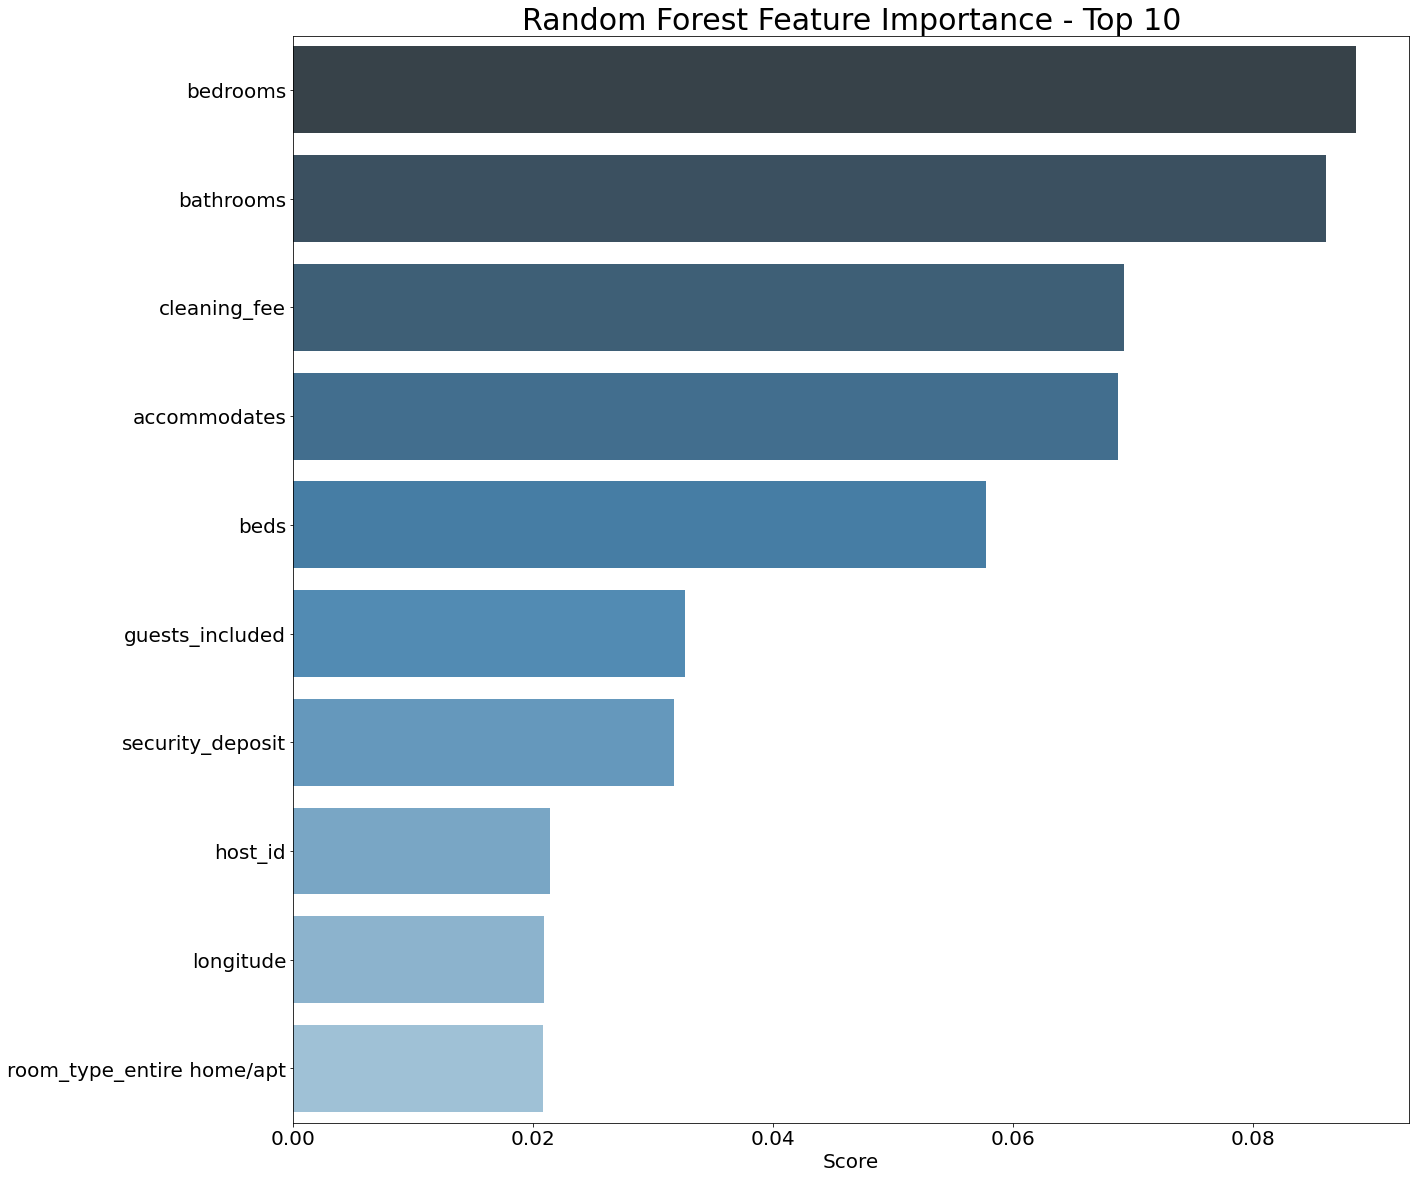

In [79]:
feature_importances = grid_search.best_estimator_.feature_importances_
data_one = pd.DataFrame(feature_importances,x_train.columns)
data_one.rename(columns={0:"score"}, inplace=True)
data_one.sort_values(by=['score'], inplace=True,ascending=False)

fig = plt.figure(figsize = (20,20))
a = sns.barplot(x="score", y='index', data=data_one[:10].reset_index(),palette="Blues_d")
a.set_xlabel("Score",fontsize=20)
a.set_ylabel("",fontsize=20)
a.tick_params(labelsize=20)
a.set_title('Random Forest Feature Importance - Top 10',fontsize=30)

### III - XGBoost

In [80]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [81]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
}

In [82]:
params['eval_metric'] = "mae"

In [83]:
num_boost_round = 999

In [84]:
#early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[15:39:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:86.37569
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:62.58235
[2]	Test-mae:48.65411
[3]	Test-mae:41.39929
[4]	Test-mae:37.72425
[5]	Test-mae:36.13873
[6]	Test-mae:35.41829
[7]	Test-mae:34.94027
[8]	Test-mae:34.87602
[9]	Test-mae:34.68075
[10]	Test-mae:34.52748
[11]	Test-mae:34.55331
[12]	Test-mae:34.46256
[13]	Test-mae:34.23208
[14]	Test-mae:34.24285
[15]	Test-mae:34.05849
[16]	Test-mae:34.10617
[17]	Test-mae:34.02416
[18]	Test-mae:33.99873
[19]	Test-mae:33.88696
[20]	Test-mae:33.67806
[21]	Test-mae:33.66195
[22]	Test-mae:33.60731
[23]	Test-mae:33.56328
[24]	Test-mae:33.64202
[25]	Test-mae:33.61896
[26]	Test-mae:33.62646
[27]	Test-mae:33.62418
[28]	Test-mae:33.62085
[29]	Test-mae:33.64677
[30]	Test-mae:33.67816
[31]	Test-mae:33.70187
[32]	Test-mae:33.66538
[33]	Test-mae:33.66734
Stopping. Best iteration:
[23]	Test-mae:33.56

In [85]:
print("Early Stopping Best Mean Absolute Error: {} with {} rounds".format(round(model.best_score,4),model.best_iteration+1))

Early Stopping Best Mean Absolute Error: 33.5633 with 24 rounds


In [86]:
#cross validation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

[15:39:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        89.947984       0.677450      90.096013      3.235841
1        64.234570       0.520319      65.300911      3.120498
2        47.877525       0.545692      50.749016      2.741538
3        38.424948       0.615927      43.449912      2.736393
4        33.055113       0.662609      40.003271      2.704862
5        30.001450       0.671013      38.464051      2.570884
6        28.009983       0.611144      37.737282      2.463594
7        26.612503       0.597560      37.488641      2.299980
8        25.518900       0.568870      37.342056      2.058792
9        24.732629       0.620923      37.400773      1.948838
10       23.873424       0.560006      37.323633      1.944707
11       23.295640       0.515320      37.188931      1.961825
12       22.636526       0.555182      37.358110      1.948017
13       22.032842       0.374695      37.250826      1.973084
14       21.557270       0.338367      37.214570      1.973909
15       21.185681       0.281432      37.231088      1.931651
16       20.716577       0.409745      37.160272      1.914440
17       20.163922       0.449975      37.072652      1.938335
18       19.765205       0.491027      37.081559      1.929785
19       19.398252       0.528375      37.080247      1.901348
20       19.050669       0.541771      36.967332      1.883088
21       18.765862       0.466531      36.984436      1.888143
22       18.503995       0.468385      36.930255      1.916120
23       18.120155       0.412111      36.867529      1.906164
24       17.914851       0.420998      36.848397      1.887802
25       17.683822       0.405036      36.844810      1.882415
26       17.455843       0.358496      36.798096      1.913779
27       17.180968       0.328215      36.842940      1.912945
28       16.864918       0.462491      36.759467      1.829572

In [87]:
cv_results['test-mae-mean'].min()
print("CV Best Mean Absolute Error: {}".format(round(cv_results['test-mae-mean'].min(),4)))

CV Best Mean Absolute Error: 36.7595


In [88]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,30)
    for min_child_weight in range(1,30)
]

In [89]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best Max Depth: {}, Best Min Child Weight: {}, Mean Absolute Error: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=1, min_child_weight=1
[15:39:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.857956 for 237 rounds
CV with max_depth=1, min_child_weight=2
[15:39:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[

	MAE 38.408777 for 137 rounds
CV with max_depth=1, min_child_weight=13
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.5321998 for 138 rounds
CV with max_depth=1, min_child_weight=14
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecate

	MAE 38.13424 for 276 rounds
CV with max_depth=1, min_child_weight=25
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.6354942 for 141 rounds
CV with max_depth=1, min_child_weight=26
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 36.5429862 for 115 rounds
CV with max_depth=2, min_child_weight=8
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.6089798 for 105 rounds
CV with max_depth=2, min_child_weight=9
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.149912 for 62 rounds
CV with max_depth=2, min_child_weight=20
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.919062000000004 for 91 rounds
CV with max_depth=2, min_child_weight=21
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 36.2926658 for 55 rounds
CV with max_depth=3, min_child_weight=3
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.3151436 for 45 rounds
CV with max_depth=3, min_child_weight=4
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 36.6149978 for 72 rounds
CV with max_depth=3, min_child_weight=15
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.636731 for 68 rounds
CV with max_depth=3, min_child_weight=16
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated 

	MAE 36.4491778 for 60 rounds
CV with max_depth=3, min_child_weight=27
[15:40:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.5200738 for 57 rounds
CV with max_depth=3, min_child_weight=28
[15:40:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:38] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 36.446228000000005 for 41 rounds
CV with max_depth=4, min_child_weight=10
[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.223622999999996 for 56 rounds
CV with max_depth=4, min_child_weight=11
[15:40:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear i

	MAE 36.6945068 for 42 rounds
CV with max_depth=4, min_child_weight=22
[15:40:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.5802712 for 31 rounds
CV with max_depth=4, min_child_weight=23
[15:40:52] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:52] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 36.24728699999999 for 37 rounds
CV with max_depth=5, min_child_weight=5
[15:40:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.4247666 for 37 rounds
CV with max_depth=5, min_child_weight=6
[15:41:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depre

	MAE 36.5039176 for 48 rounds
CV with max_depth=5, min_child_weight=17
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.898058400000004 for 29 rounds
CV with max_depth=5, min_child_weight=18
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 36.405323200000005 for 37 rounds
CV with max_depth=5, min_child_weight=29
[15:41:12] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.7429748 for 48 rounds
CV with max_depth=6, min_child_weight=1
[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 36.838116400000004 for 20 rounds
CV with max_depth=6, min_child_weight=12
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.6023842 for 29 rounds
CV with max_depth=6, min_child_weight=13
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 36.684823800000004 for 30 rounds
CV with max_depth=6, min_child_weight=24
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.741478799999996 for 21 rounds
CV with max_depth=6, min_child_weight=25
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear i

	MAE 37.1683754 for 22 rounds
CV with max_depth=7, min_child_weight=7
[15:41:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.109306399999994 for 11 rounds
CV with max_depth=7, min_child_weight=8
[15:41:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depr

	MAE 37.2668944 for 7 rounds
CV with max_depth=7, min_child_weight=19
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.938416399999994 for 30 rounds
CV with max_depth=7, min_child_weight=20
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 36.8271316 for 9 rounds
CV with max_depth=8, min_child_weight=2
[15:41:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.990407 for 27 rounds
CV with max_depth=8, min_child_weight=3
[15:42:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in 

	MAE 37.352841999999995 for 10 rounds
CV with max_depth=8, min_child_weight=14
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.866179599999995 for 8 rounds
CV with max_depth=8, min_child_weight=15
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is

	MAE 37.5182098 for 12 rounds
CV with max_depth=8, min_child_weight=26
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.114071 for 24 rounds
CV with max_depth=8, min_child_weight=27
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated 

	MAE 36.99478860000001 for 11 rounds
CV with max_depth=9, min_child_weight=9
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.142582 for 7 rounds
CV with max_depth=9, min_child_weight=10
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprec

	MAE 37.3354858 for 8 rounds
CV with max_depth=9, min_child_weight=21
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.1181742 for 9 rounds
CV with max_depth=9, min_child_weight=22
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 37.455931199999995 for 9 rounds
CV with max_depth=10, min_child_weight=4
[15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.1442528 for 8 rounds
CV with max_depth=10, min_child_weight=5
[15:42:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depr

	MAE 36.7446058 for 14 rounds
CV with max_depth=10, min_child_weight=16
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.321514 for 9 rounds
CV with max_depth=10, min_child_weight=17
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.490687799999996 for 21 rounds
CV with max_depth=10, min_child_weight=28
[15:42:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.4446838 for 11 rounds
CV with max_depth=10, min_child_weight=29
[15:42:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now 

	MAE 37.5900376 for 7 rounds
CV with max_depth=11, min_child_weight=11
[15:42:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.064476 for 17 rounds
CV with max_depth=11, min_child_weight=12
[15:42:55] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:55] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.19388579999999 for 8 rounds
CV with max_depth=11, min_child_weight=23
[15:43:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.609474399999996 for 11 rounds
CV with max_depth=11, min_child_weight=24
[15:43:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear i

	MAE 37.3886548 for 9 rounds
CV with max_depth=12, min_child_weight=6
[15:43:09] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:09] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:09] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:09] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:09] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.782567 for 10 rounds
CV with max_depth=12, min_child_weight=7
[15:43:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:10] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 37.0134866 for 7 rounds
CV with max_depth=12, min_child_weight=18
[15:43:23] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:23] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:23] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.2134092 for 8 rounds
CV with max_depth=12, min_child_weight=19
[15:43:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.62147280000001 for 7 rounds
CV with max_depth=13, min_child_weight=1
[15:43:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.3392066 for 11 rounds
CV with max_depth=13, min_child_weight=2
[15:43:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depr

	MAE 37.497760199999995 for 7 rounds
CV with max_depth=13, min_child_weight=13
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.6369192 for 10 rounds
CV with max_depth=13, min_child_weight=14
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now d

	MAE 37.6841576 for 7 rounds
CV with max_depth=13, min_child_weight=25
[15:43:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.501190799999996 for 8 rounds
CV with max_depth=13, min_child_weight=26
[15:43:52] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:52] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.82014540000001 for 7 rounds
CV with max_depth=14, min_child_weight=8
[15:44:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.517437799999996 for 9 rounds
CV with max_depth=14, min_child_weight=9
[15:44:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is n

	MAE 37.1493324 for 8 rounds
CV with max_depth=14, min_child_weight=20
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.06975619999999 for 8 rounds
CV with max_depth=14, min_child_weight=21
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 37.4585356 for 10 rounds
CV with max_depth=15, min_child_weight=3
[15:44:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.010013400000005 for 8 rounds
CV with max_depth=15, min_child_weight=4
[15:44:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 37.3578988 for 8 rounds
CV with max_depth=15, min_child_weight=15
[15:44:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:25] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.15516960000001 for 9 rounds
CV with max_depth=15, min_child_weight=16
[15:44:26] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:26] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 37.6708238 for 8 rounds
CV with max_depth=15, min_child_weight=27
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.3652192 for 9 rounds
CV with max_depth=15, min_child_weight=28
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.5584222 for 8 rounds
CV with max_depth=16, min_child_weight=10
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.9963102 for 10 rounds
CV with max_depth=16, min_child_weight=11
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecate

	MAE 37.6463638 for 7 rounds
CV with max_depth=16, min_child_weight=22
[15:44:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.5950288 for 7 rounds
CV with max_depth=16, min_child_weight=23
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.7364434 for 9 rounds
CV with max_depth=17, min_child_weight=5
[15:45:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.859239200000005 for 9 rounds
CV with max_depth=17, min_child_weight=6
[15:45:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depr

	MAE 37.4528978 for 7 rounds
CV with max_depth=17, min_child_weight=17
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.461402199999995 for 7 rounds
CV with max_depth=17, min_child_weight=18
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.102255400000004 for 10 rounds
CV with max_depth=17, min_child_weight=29
[15:45:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.844512200000004 for 10 rounds
CV with max_depth=18, min_child_weight=1
[15:45:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear 

	MAE 37.1986412 for 7 rounds
CV with max_depth=18, min_child_weight=12
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.348109400000006 for 9 rounds
CV with max_depth=18, min_child_weight=13
[15:45:48] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:48] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.7290466 for 8 rounds
CV with max_depth=18, min_child_weight=24
[15:46:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:02] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.741999799999995 for 9 rounds
CV with max_depth=18, min_child_weight=25
[15:46:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:03] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.9889916 for 10 rounds
CV with max_depth=19, min_child_weight=7
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.171633 for 8 rounds
CV with max_depth=19, min_child_weight=8
[15:46:14] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:14] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 37.0939338 for 8 rounds
CV with max_depth=19, min_child_weight=19
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.516007200000004 for 9 rounds
CV with max_depth=19, min_child_weight=20
[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 38.4798362 for 9 rounds
CV with max_depth=20, min_child_weight=2
[15:46:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:29] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.10055 for 9 rounds
CV with max_depth=20, min_child_weight=3
[15:46:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in 

	MAE 37.6215502 for 9 rounds
CV with max_depth=20, min_child_weight=14
[15:46:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:39] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.165481 for 8 rounds
CV with max_depth=20, min_child_weight=15
[15:46:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated 

	MAE 37.6440394 for 8 rounds
CV with max_depth=20, min_child_weight=26
[15:46:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.73860839999999 for 10 rounds
CV with max_depth=20, min_child_weight=27
[15:46:48] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:48] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.741587200000005 for 8 rounds
CV with max_depth=21, min_child_weight=9
[15:46:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.7386626 for 8 rounds
CV with max_depth=21, min_child_weight=10
[15:46:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 37.3119766 for 7 rounds
CV with max_depth=21, min_child_weight=21
[15:47:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.510284999999996 for 7 rounds
CV with max_depth=21, min_child_weight=22
[15:47:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 38.129271800000005 for 9 rounds
CV with max_depth=22, min_child_weight=4
[15:47:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.591350399999996 for 9 rounds
CV with max_depth=22, min_child_weight=5
[15:47:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is 

	MAE 37.17374120000001 for 7 rounds
CV with max_depth=22, min_child_weight=16
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.5656996 for 9 rounds
CV with max_depth=22, min_child_weight=17
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:32] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 37.71345 for 8 rounds
CV with max_depth=22, min_child_weight=28
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.179996599999996 for 10 rounds
CV with max_depth=22, min_child_weight=29
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 36.94489600000001 for 8 rounds
CV with max_depth=23, min_child_weight=11
[15:47:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.299112799999996 for 7 rounds
CV with max_depth=23, min_child_weight=12
[15:48:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:00] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is

	MAE 37.3166458 for 9 rounds
CV with max_depth=23, min_child_weight=23
[15:48:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:07] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.7869668 for 8 rounds
CV with max_depth=23, min_child_weight=24
[15:48:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:08] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.813727 for 8 rounds
CV with max_depth=24, min_child_weight=6
[15:48:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.9114196 for 10 rounds
CV with max_depth=24, min_child_weight=7
[15:48:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 37.4792542 for 7 rounds
CV with max_depth=24, min_child_weight=18
[15:48:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.1803922 for 8 rounds
CV with max_depth=24, min_child_weight=19
[15:48:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.7426468 for 10 rounds
CV with max_depth=25, min_child_weight=1
[15:48:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.502115399999994 for 10 rounds
CV with max_depth=25, min_child_weight=2
[15:48:46] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:46] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.364925400000004 for 7 rounds
CV with max_depth=25, min_child_weight=13
[15:49:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:05] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.6329192 for 9 rounds
CV with max_depth=25, min_child_weight=14
[15:49:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.743373 for 9 rounds
CV with max_depth=25, min_child_weight=25
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.60189200000001 for 8 rounds
CV with max_depth=25, min_child_weight=26
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depr

	MAE 37.757312 for 11 rounds
CV with max_depth=26, min_child_weight=8
[15:49:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:42] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.396038 for 22 rounds
CV with max_depth=26, min_child_weight=9
[15:49:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 37.48679 for 7 rounds
CV with max_depth=26, min_child_weight=20
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.31318339999999 for 7 rounds
CV with max_depth=26, min_child_weight=21
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:54] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depre

	MAE 37.998708 for 9 rounds
CV with max_depth=27, min_child_weight=3
[15:50:04] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:04] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:04] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:04] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:04] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.147154799999996 for 9 rounds
CV with max_depth=27, min_child_weight=4
[15:50:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:06] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depre

	MAE 37.147216 for 9 rounds
CV with max_depth=27, min_child_weight=15
[15:50:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.167833 for 7 rounds
CV with max_depth=27, min_child_weight=16
[15:50:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated i

	MAE 37.723922 for 9 rounds
CV with max_depth=27, min_child_weight=27
[15:50:27] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:27] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:27] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:27] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:27] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.698153399999995 for 10 rounds
CV with max_depth=27, min_child_weight=28
[15:50:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:28] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.5770574 for 7 rounds
CV with max_depth=28, min_child_weight=10
[15:50:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.961659399999995 for 8 rounds
CV with max_depth=28, min_child_weight=11
[15:50:48] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:48] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.4473952 for 7 rounds
CV with max_depth=28, min_child_weight=22
[15:50:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.274987800000005 for 9 rounds
CV with max_depth=28, min_child_weight=23
[15:50:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.59000999999999 for 11 rounds
CV with max_depth=29, min_child_weight=5
[15:51:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.8038322 for 9 rounds
CV with max_depth=29, min_child_weight=6
[15:51:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now depr

	MAE 37.5615738 for 9 rounds
CV with max_depth=29, min_child_weight=17
[15:51:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.479254000000005 for 7 rounds
CV with max_depth=29, min_child_weight=18
[15:51:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:36] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now de

	MAE 37.1883356 for 10 rounds
CV with max_depth=29, min_child_weight=29
[15:51:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:44] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.7403114 for 10 rounds
Best Max Depth: 4, Best Min Child Weight: 5, Mean Absolute Error: 35.795248400000006


In [90]:
params['max_depth'] = 4
params['min_child_weight'] = 5

In [91]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(1,10)]
    for colsample in [i/10. for i in range(1,10)]
]

In [92]:
min_mae = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best bubsample: {}, Best colsamle{}, Mean Absolute Error: {}".format(best_params[0], best_params[1], round(min_mae),4))

CV with subsample=0.9, colsample=0.9
[15:51:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:45] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.3093298 for 55 rounds
CV with subsample=0.9, colsample=0.8
[15:51:46] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:46] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:

	MAE 36.2766634 for 35 rounds
CV with subsample=0.8, colsample=0.6
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 36.418965400000005 for 35 rounds
CV with subsample=0.8, colsample=0.5
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 37.192662 for 28 rounds
CV with subsample=0.7, colsample=0.3
[15:51:56] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:56] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:56] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:56] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:56] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.3527116 for 31 rounds
CV with subsample=0.7, colsample=0.2
[15:51:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor

	MAE 38.68318419999999 for 50 rounds
CV with subsample=0.5, colsample=0.9
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 37.698661799999996 for 32 rounds
CV with subsample=0.5, colsample=0.8
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now dep

	MAE 39.0147568 for 31 rounds
CV with subsample=0.4, colsample=0.6
[15:52:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:11] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.194776399999995 for 40 rounds
CV with subsample=0.4, colsample=0.5
[15:52:12] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:12] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated

	MAE 39.51909 for 23 rounds
CV with subsample=0.3, colsample=0.3
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 38.4396858 for 28 rounds
CV with subsample=0.3, colsample=0.2
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor 

	MAE 43.0330458 for 28 rounds
CV with subsample=0.1, colsample=0.9
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 42.919496 for 15 rounds
CV with subsample=0.1, colsample=0.8
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor

In [93]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8

In [94]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    params['eta'] = eta
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['mae'],early_stopping_rounds=10)
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best eta: {}, Mean Absolute Error: {}".format(best_params, round(min_mae,4)))

CV with eta=0.3
[15:52:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 13.7 s, sys: 29.7 ms, total: 13.7 s
Wall time: 591 ms
	MAE 35.7831628 for 36 rounds

CV with eta=0.2
[15:52:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor

In [95]:
params['eta'] = .05

In [96]:
params

{'max_depth': 4,
 'min_child_weight': 5,
 'eta': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'objective': 'reg:linear',
 'eval_metric': 'mae'}

In [97]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[15:52:47] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:116.27483
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:110.51990
[2]	Test-mae:105.02860
[3]	Test-mae:99.84593
[4]	Test-mae:94.88167
[5]	Test-mae:90.13232
[6]	Test-mae:85.66419
[7]	Test-mae:81.51744
[8]	Test-mae:77.48331
[9]	Test-mae:73.72224
[10]	Test-mae:70.24558
[11]	Test-mae:66.99597
[12]	Test-mae:64.13018
[13]	Test-mae:61.40110
[14]	Test-mae:58.91457
[15]	Test-mae:56.69002
[16]	Test-mae:54.67277
[17]	Test-mae:52.83367
[18]	Test-mae:51.11627
[19]	Test-mae:49.58608
[20]	Test-mae:48.27215
[21]	Test-mae:47.00634
[22]	Test-mae:45.88055
[23]	Test-mae:44.88217
[24]	Test-mae:43.96600
[25]	Test-mae:43.19807
[26]	Test-mae:42.45756
[27]	Test-mae:41.81324
[28]	Test-mae:41.23725
[29]	Test-mae:40.76979
[30]	Test-mae:40.33357
[31]	Test-mae:39.90535
[32]	Test-mae:39.56007
[33]	Test-mae:39.23747
[34]	Test-mae:38.85060
[35]	Test-mae:38.61

In [98]:
print("Best Mean Absolute Error: {} in {} rounds".format(round(model.best_score,4), model.best_iteration+1))

Best Mean Absolute Error: 33.2781 in 202 rounds


In [99]:
print('Improvment from baseline: {}'.format(round((baseline_mae-model.best_score),4)))
print('Hyperparameter Tuning Improvement: {}'.format(round((33.5633-model.best_score),4)))

Improvment from baseline: 28.7694
Hyperparameter Tuning Improvement: 0.2852


Text(0.5, 1.0, 'XGBoost Feature Importance - Top 10')

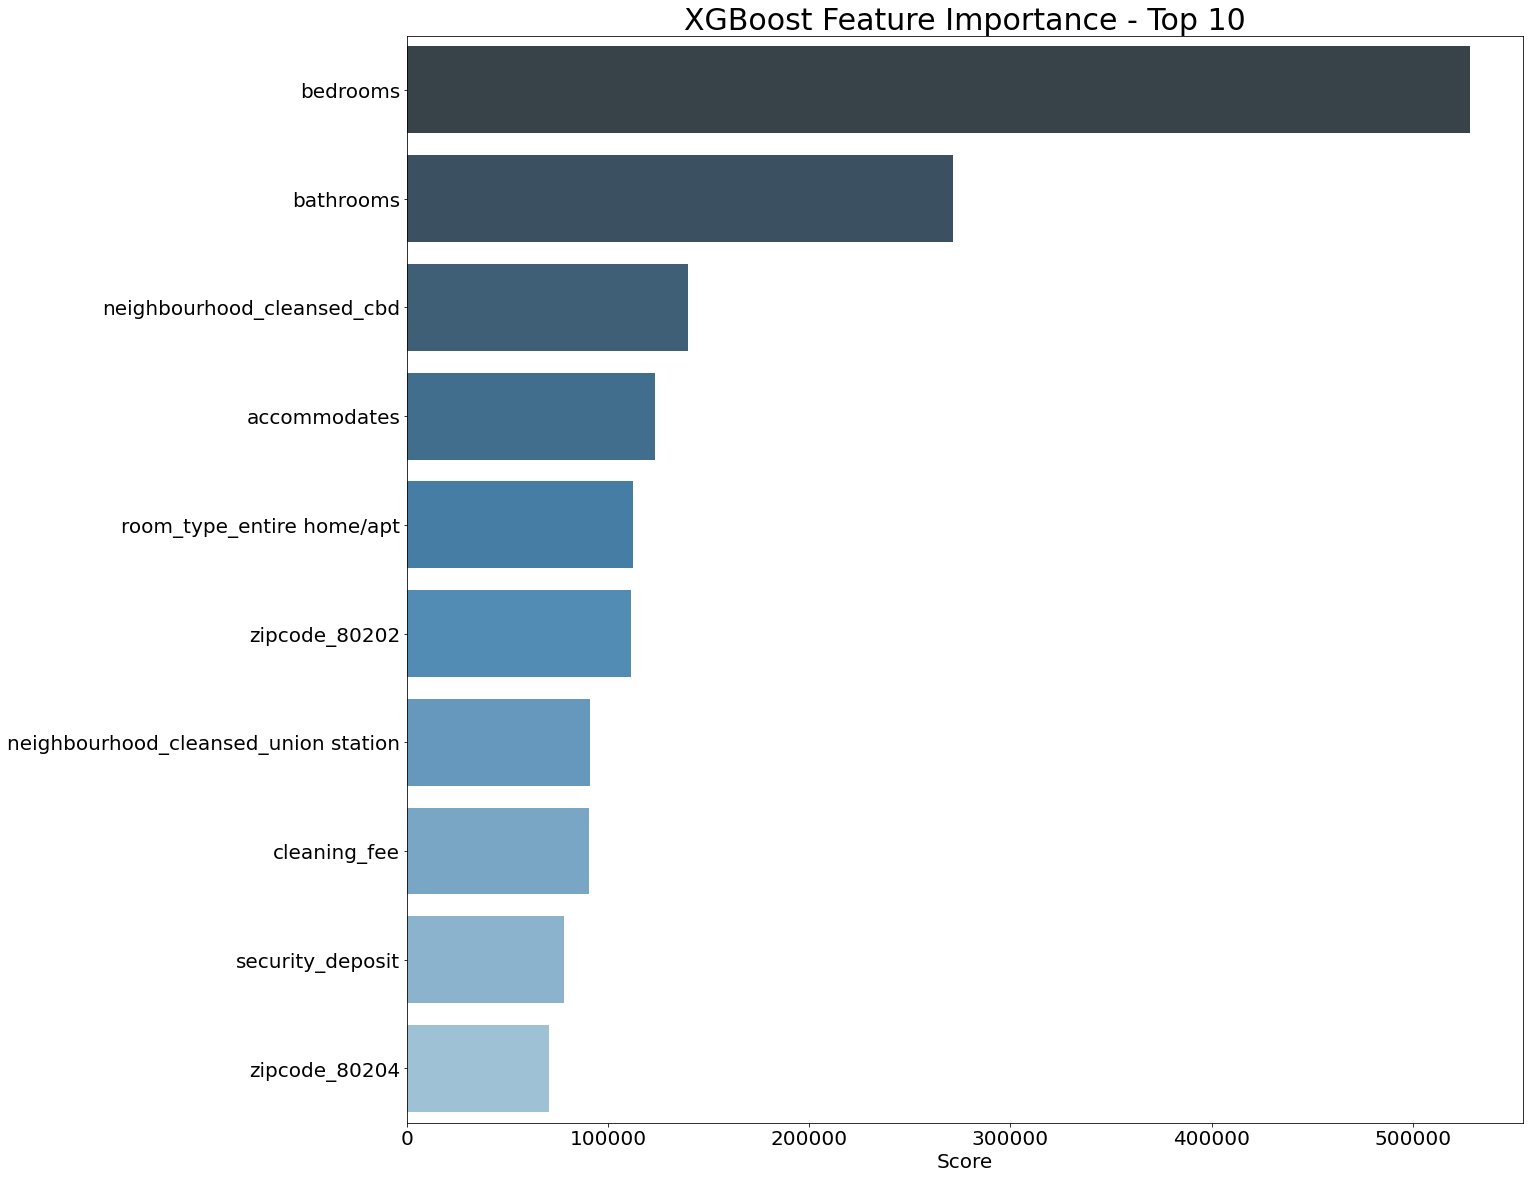

In [100]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_two = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)


fig = plt.figure(figsize = (20,20))
b = sns.barplot(x="score", y='index', data=data_two[:10].reset_index(),palette="Blues_d")
b.set_xlabel("Score",fontsize=20)
b.set_ylabel("",fontsize=20)
b.tick_params(labelsize=20)
b.set_title('XGBoost Feature Importance - Top 10',fontsize=30)

In [101]:
results =  {'Baseline': [62.0476], 'XGBoost': [33.2781], 'Random Forest': [32.8499]}
result_df = pd.DataFrame(data=results)

Text(0.5, 1.0, 'Model Performance')

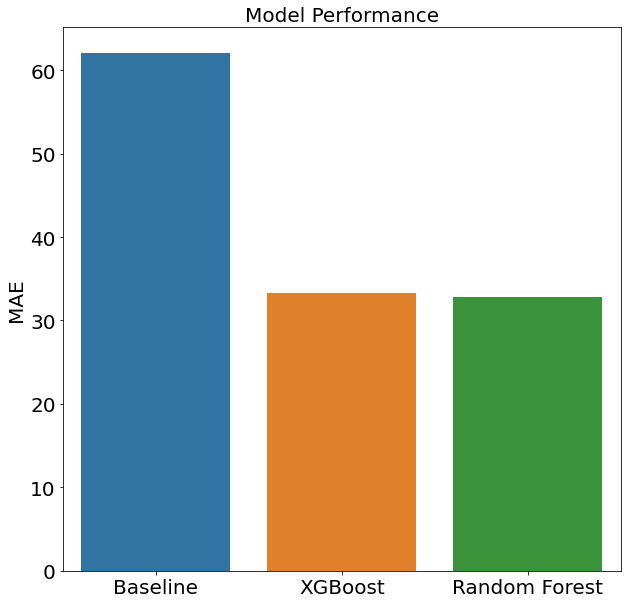

In [102]:
fig = plt.figure(figsize = (10,10))
ax = sns.barplot(data=result_df)
ax.set_ylabel("MAE",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_title('Model Performance',fontsize=20)